## Objective
THIS IS TEMPORARY FILE

Too much code in si_rec5.ipynb (jupyter and/or vscode is slowing down), so code is deleted from si_rec5.ipynb and saved here

## General setup

In [1]:
%load_ext autoreload

In [2]:
from importlib import reload
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from multiprocessing import Pool
from pandas import DataFrame

from tqdm import tqdm

%autoreload 2
from src.run_alg import si_rec5 as F
from src.sorters.prop_signal import PropSignal, PropUnit
from src.sorters.kilosort import get_experts_kilosort
from src.sorters.base import SpikeSorter, Unit
from src.comparison import Comparison, DummySorter
from src import utils, plot
from src.sorters.kilosort import get_experts_kilosort

In [3]:
import pickle
from joblib import Parallel, delayed
from copy import deepcopy
from pathlib import Path

# Test parallel processing with joblib
# from joblib import Parallel, delayed
# def test(_):
#     data = np.random.random(1000).reshape((-1, 2))
#     gmm = GaussianMixture(n_components=6, init_params="kmeans", covariance_type="diag")
#     gmm.fit(data)
#     return None
    
# # Full run 
# # all_props = []
# Parallel(n_jobs=20)(delayed(test)(x) for x in tqdm(range(300)))

In [80]:
recording = RECORDING = utils.rec_si()  # lowercase for easier implementation in .py functions. uppercase for jupyter notebook
samp_freq = RECORDING.get_sampling_frequency()
chans_rms = CHANS_RMS = utils.chans_rms_si()
num_elecs = RECORDING.get_num_channels()

COC_DICT_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/coc_dicts")  # /{elec}.pickle

# cross_times = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/spike_times.npy", allow_pickle=True)
# cross_amps = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/spike_amps.npy", allow_pickle=True)
# NOTE: For DL, cross_amps retain sign of original data (i.e. positive or negative)

# Need to eliminate some crosses with 0 amplitude (bug in raw_recording.ipynb in DL project, not sure why/where) --> handle this when forming coc_dicts
# cross_times = []
# cross_amps = []
# for times, amps in tqdm(zip(cross_times_og, cross_amps_og), total=len(cross_times_og)):
#     ind = ~np.isclose(amps, 0)
#     cross_times.append(np.array(times)[ind])
#     cross_amps.append(np.array(amps)[ind])

# TODO: How DL detects cross_amps needs to be fixed
# total = 0
# for amps in tqdm(cross_amps):
#     amps = np.array(amps)
#     ind = amps < 0
#     total += sum(ind)

# print(total)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


Recording does not have scaled traces. Setting gain to 0.195


In [5]:
# TRAINING_FRAMES for forming sequences while TESTING_FRAMES if for comparing with kilosort
TRAINING_FRAMES = (0, 5*60*1000)  # 0 min to 5 min in recording (in ms)
TESTING_FRAMES = (5*60*1000, 10*60*1000)  # 5 min to 10 min in recording (in ms)

In [6]:
"""  closest_elecs
Index in closest_elecs is electrode index.
Each element is list containing electrode indices sorted by
ascending distance from index electrode (excluding index electrode itself)
"""
all_closest_elecs = []

elec_locs = RECORDING.get_channel_locations()
for elec in range(num_elecs):
    elec_ind = []
    dists = []
    x1, y1 = elec_locs[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = elec_locs[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    all_closest_elecs.append(np.array(elec_ind)[order])   
    

def calc_elec_dist(elec1, elec2):
    # Calculate the spatial distance between two electrodes
    x1, y1 = elec_locs[elec1]
    x2, y2 = elec_locs[elec2]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def get_nearby_elecs(ref_elec, max_dist=100):
    nearby_elecs = []
    for elec in all_closest_elecs[ref_elec]:
        if calc_elec_dist(ref_elec, elec) <= max_dist:
            nearby_elecs.append(elec)
    return nearby_elecs

def get_merge_elecs(ref_elec, max_dist=100):
    # [ref_elec] + get_nearby_elecs
    return [ref_elec] + get_nearby_elecs(ref_elec, max_dist)

mean amp: -52.3660774230957


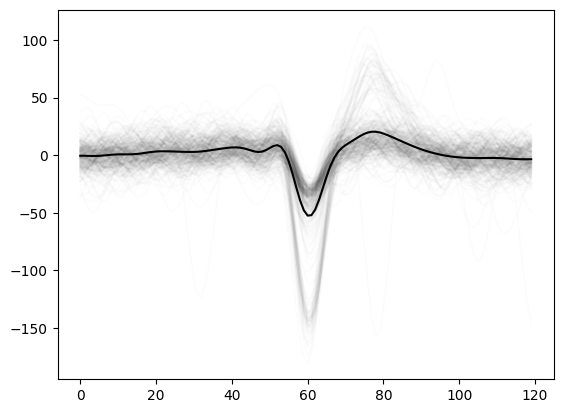

In [ ]:
# Plot cross times on one channel
CHAN = 0
N = 300

N_BEFORE = 60
N_AFTER = 60

np.random.seed(231)
##
traces = [] 
for _ in range(N):
    time_ms = np.random.choice(cross_times[CHAN])
    time = int(time_ms * RECORDING.get_sampling_frequency())
    trace = RECORDING.get_traces_filt(time-N_BEFORE, time+N_AFTER, CHAN).flatten()
    
    plt.plot(trace, color="black", alpha=0.01)
    
    traces.append(trace)
traces = np.stack(traces)
trace_mean = np.mean(traces, axis=0)
print(f"mean amp: {np.min(trace_mean)}")

plt.plot(trace_mean, color="black")

plt.show()

## Form propagations
Form sequence backbones on root electrode  
Merge sequence backbones with the same root electrode  
Assign spikes to sequences  
Merge sequences with the same root electrode (intraelectrode merging)  
Merge sequences with different root electrodes (interelectrode merging)  

### Run once for recording

In [ ]:
# Reformat cross_times into one long array
all_crossings = []  # [(elec_idx, time, amp)]
elec_crossings_ind = [[] for _ in range(len(cross_times))]  # ith element for elec idx i. Contains ind in all_crossings for elec idx i's crossings

pointers = [0] * len(cross_times)  # Where to index next time in each electrode's crossings (So all_crossings is sorted in time)
for t in tqdm(range(sum((len(t) for t in cross_times)))):
    next_time = np.inf
    next_amp = None
    next_elec = None
    for elec, idx in enumerate(pointers):
        if idx == len(cross_times[elec]):
            continue
        
        time = cross_times[elec][idx]
        if time < next_time:
            next_time = time
            next_amp = cross_amps[elec][idx]
            next_elec = elec
    
    all_crossings.append((next_elec, next_time, next_amp))
    elec_crossings_ind[next_elec].append(t)
    pointers[next_elec] += 1

100%|██████████| 7034141/7034141 [08:49<00:00, 13296.60it/s]


In [82]:
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/all_crossings.npy", np.array(all_crossings, dtype=object))
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/elec_crossings_ind.npy", np.array(elec_crossings_ind, dtype=object))

all_crossings = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/all_crossings.npy", allow_pickle=True)
elec_crossings_ind = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/elec_crossings_ind.npy", allow_pickle=True)
# Reformat for faster retrieval
all_crossings = [tuple(cross) for cross in all_crossings]
elec_crossings_ind = [tuple(ind) for ind in elec_crossings_ind]  # [(elec's cross times ind in all_crossings)]

In [85]:
def find_elec_cocs(elec_idx,
                   min_amp_ratio=0.9, coactivation_window=0.5,
                   max_elec_dist=200):
    """
    For electrode, return dictionary of
    {
        (elec cross time, elec cross amp): [(other elec idx, other elec cross time, other elec amp)]
    }
    
    If (elec cross time, elec cross amp) not in dictionary, then there was no cooccurrence with another electrode
    
    min_amp_ratio: For all tar_amps for ref_amp, ref_amp / tar_amp has to be at least min_amp_ratio for coocurrence to count as one
        AKA: max_v
    """
    
    coc_dict = {}
    for ref_idx in elec_crossings_ind[elec_idx]:
        _, ref_time, ref_amp = all_crossings[ref_idx]       
        cocs = []
        
        # while idx-1 >= 0 and ref_time - all_crossings[idx-1][1] <= coactivation_window:
        #     idx -= 1
        #     cocs.append(all_crossings[idx])
                   
        # while idx+1 < len(all_crossings) and all_crossings[idx+1][1] - ref_time <= coactivation_window:
        #     idx += 1
        #     cocs.append(all_crossings[idx])
        
        for inc in (-1, 1):  # to handle cocs occurring before and after ref_time, respectively
            idx = ref_idx
            while (0 <= idx+inc < len(all_crossings)) and np.abs(ref_time - all_crossings[idx + inc][1]) <= coactivation_window:
                idx += inc
                tar_crossing = all_crossings[idx]
                
                # TODO: Implement a better solution? (check 231012_prop_notes, around slide 6)                
                if ref_amp / tar_crossing[2] < min_amp_ratio and calc_elec_dist(elec_idx, tar_crossing[0]) <= max_elec_dist:
                    break
                cocs.append(tar_crossing)
            else:
                continue  # Check next inc for cocs
            break  # If while loop was broken, then stop looking for cocs
        else:  # If for loop was not broken, then add cocs
            if len(cocs) > 0:                
                coc_dict[(ref_time, ref_amp)] = cocs
        
        # Not using for loop (instead, this needs copy and pasting)
        # idx = ref_idx
        # while idx-1 >= 0 and ref_time - all_crossings[idx-1][1] <= coactivation_window:  # Add cocs occurring before ref_time
        #     idx -= 1
        #     tar_crossing = all_crossings[idx]
        #     if np.abs(ref_amp / tar_crossing[2]) < min_amp_ratio:
        #         break
        #     cocs.append(tar_crossing)
        # else:           
        #     idx = ref_idx
        #     while idx+1 < len(all_crossings) and all_crossings[idx+1][1] - ref_time <= coactivation_window:  # Add cocs occurring after ref_time
        #         idx += 1
        #         tar_crossing = all_crossings[idx]           
        #         if np.abs(ref_amp / tar_crossing[2]) < min_amp_ratio:
        #             break
        #         cocs.append(tar_crossing)
        #     else:
        #         if len(cocs) > 0:
        #             coc_dict[(ref_time, ref_amp)] = cocs
                    
    return coc_dict

MIN_AMP_RATIO = 0
def save_coc_dict(elec):
    coc_dict = find_elec_cocs(elec, min_amp_ratio=MIN_AMP_RATIO)
    with open(COC_DICT_ROOT / f"max{MIN_AMP_RATIO}/{elec}.pickle", "wb") as f:
        pickle.dump(coc_dict, f, pickle.HIGHEST_PROTOCOL)

with Pool(processes=20) as pool:
    tasks = range(num_elecs)
    for _ in tqdm(pool.imap_unordered(save_coc_dict, tasks), total=len(tasks)):
        pass

100%|██████████| 248/248 [01:04<00:00,  3.86it/s]


### Now form propagations

In [89]:
# Load cross times quickly
def load_coc_dict(elec, max_v=0.9, time_frame=None):
    with open(COC_DICT_ROOT / f"max{max_v}/{elec}.pickle", "rb") as f:
        coc_dict = pickle.load(f)
    if time_frame is not None:
        start_ms, end_ms = time_frame
        new_coc_dict = {}
        for (root_time, root_amp), cocs in coc_dict.items():
            if start_ms <= root_time <= end_ms:
                new_cocs = []
                for elec, time, amp in cocs:
                    if start_ms <= time <= end_ms:
                        new_cocs.append((elec, time, amp))
                if len(new_cocs) > 0:
                    new_coc_dict[(root_time, root_amp)] = new_cocs
        coc_dict = new_coc_dict
    return coc_dict


# # Testing find_elec_cocs   
# # coc_dict = find_elec_cocs(0, min_amp_ratio=0.9, max_elec_dist=200)
# ref_elec = 100
# ##
# coc_dict = load_coc_dict(ref_elec)
# print(len(coc_dict))
    
# times = []
# for (ref_time, ref_amp), cocs in coc_dict.items():
#     for elec, time, amp in cocs:
#         if elec == 97:
#             times.append(ref_time)
# print(len(times))

# unit = Unit(0, times, ref_elec, RECORDING)
# unit.plot(chans_rms=CHANS_RMS)
# plt.show()

In [ ]:
# OLD - Form CocClusters
def get_coc_matrix(comp_elec, coc_dict, allowed_root_times=None):
    coc_matrix = []
    for (root_time, root_amp), cocs in coc_dict.items():
        if allowed_root_times is not None and root_time not in allowed_root_times:
            continue
        
        comp_times = []  # For multiple comp_elec crossings cooccuring with same root_elec crossing 
        comp_amps = []   # (this is slower and probably unnecessary than assuming only 1:1 cooccurrence)
        # ref_amps = []  # rel comp amp is comp_amp/mean(ref_amps)
        for tar_elec, tar_time, tar_amp in cocs:
            # crosses_thresh = tar_amp >= rms_thresh * chans_rms[tar_elec]
            if tar_elec == comp_elec:
                # if crosses_thresh:
                comp_times.append(tar_time)
                comp_amps.append(tar_amp)
                
        for comp_time, comp_amp in zip(comp_times, comp_amps):
            coc_matrix.append([comp_time - root_time, comp_amp/root_amp, root_time]) 

    return coc_matrix
        
class CocCluster:
    def __init__(self, coc) -> None:
        self.cocs = [coc]
        self.mean_latency = coc[0]
        self.mean_rel_amp = coc[1]
        
    def add_coc(self, coc):        
        mean_latency = len(self.cocs) * self.mean_latency + coc[0]
        mean_rel_amp = len(self.cocs) * self.mean_rel_amp + coc[1]
        
        self.cocs.append(coc)
        self.mean_latency = mean_latency / len(self.cocs)
        self.mean_rel_amp = mean_rel_amp / len(self.cocs)
        
    def calc_latency_diff(self, other):
        if isinstance(other, CocCluster):
            other_mean_latency = other.mean_latency
        else:  # Other is coc
            other_mean_latency = other[0]
        return np.abs(self.mean_latency - other_mean_latency)
    
    def calc_rel_amp_diff(self, other):
        if isinstance(other, CocCluster):
            other_mean_rel_amp = other.mean_rel_amp
        else:  # Other is coc
            other_mean_rel_amp = other[1]
        return np.abs(self.mean_rel_amp - other_mean_rel_amp) / self.mean_rel_amp 
    
    def merge(self, other):
        mean_latency = len(self.cocs) * self.mean_latency + len(other.cocs) * other.mean_latency
        mean_rel_amp = len(self.cocs) * self.mean_rel_amp + len(other.cocs) * other.mean_rel_amp
        
        self.cocs += other.cocs
        self.mean_latency = mean_latency / len(self.cocs)
        self.mean_rel_amp = mean_rel_amp / len(self.cocs)
        
    @property
    def spike_train(self):
        return np.sort([c[2] for c in self.cocs])
        

def cluster_elec_pair(coc_matrix, min_diff_start=1/samp_freq, min_cocs=100):
    # min_diff_start = 0.2
    # min_diff_start = 1e-5
    
    elec_clusters = [CocCluster(coc_matrix[0])]
    for coc in coc_matrix[1:]:
        closest_cluster = None
        min_diff = min_diff_start
        for cluster in elec_clusters:
            diff = cluster.calc_latency_diff(coc)
            if diff <= min_diff:
                closest_cluster = cluster
                min_diff = diff
        if closest_cluster is not None:
            closest_cluster.add_coc(coc)
        else:
            elec_clusters.append(CocCluster(coc))
            
    dead_clusters = set()
    while True:
        merge = None
        min_diff = min_diff_start
        for i in range(len(elec_clusters)):        
            cluster_i = elec_clusters[i]
            if cluster_i in dead_clusters:
                continue
            for j in range(i+1, len(elec_clusters)):            
                cluster_j = elec_clusters[j]
                if cluster_j in dead_clusters:
                    continue
                diff = cluster_i.calc_latency_diff(cluster_j)
                if diff <= min_diff:
                    merge = [cluster_i, cluster_j]
                    min_diff = diff
                    
        if merge is None:
            break
        
        merge[0].merge(merge[1])
        dead_clusters.add(merge[1])
    
    elec_clusters = [c for c in elec_clusters if len(c.spike_train) >= min_cocs and c not in dead_clusters]
    # elec_clusters = [c for c in elec_clusters if len(c.spike_train) >= min_cocs]
 
    return elec_clusters


def form_coc_clusters(root_elec, 
                       elec_patience=6, max_elec_dist=100,
                       time_frame=None, min_cocs=100,
                       verbose=False):
    if verbose:
        print(f"Starting with elec {root_elec}, loc: {elec_locs[root_elec]}")
    
    coc_dict = load_coc_dict(root_elec, time_frame=time_frame)
    allowed_root_times = set(key[0] for key in coc_dict.keys())
    elec_patience_counter = 0
    all_coc_clusters = []
    for comp_elec in all_closest_elecs[root_elec]: 
        if calc_elec_dist(root_elec, comp_elec) > max_elec_dist:
            if verbose:
                print(f"\nStopping search early due to max dist {max_elec_dist}")
            break
        
        if len(allowed_root_times) < min_cocs:
            if verbose:
                print(f"\nNot enough cocs to continue")
            break
                 
        if verbose: 
            print(f"\nComparing to elec {comp_elec}, loc: {elec_locs[comp_elec]}")

        coc_matrix = get_coc_matrix(comp_elec, coc_dict, allowed_root_times)
        if len(coc_matrix) == 0:
            continue
        coc_clusters = cluster_elec_pair(coc_matrix, min_cocs=min_cocs)
        
        if verbose:
            print(f"Found {len(coc_clusters)} clusters")
            
        if len(coc_clusters) > 0:
            for cluster in coc_clusters:
                allowed_root_times.difference_update(cluster.spike_train)
                cluster.root_elec = root_elec
                cluster.comp_elec = comp_elec
                all_coc_clusters.append(cluster)
        else:
            elec_patience_counter += 1
            if elec_patience_counter == elec_patience:
                break
            
    if verbose:
        print(f"\nFound {len(all_coc_clusters)} total clusters")
    return all_coc_clusters
 
root_elec = 17
coc_clusters = form_coc_clusters(root_elec, verbose=False)
print(len(coc_clusters))
# merged_clusters = merge_coc_clusters(root_elec, coc_clusters, verbose=True)

# all_coc_clusters = []
# for root_elec in range(num_elecs):
#     coc_clusters = form_coc_clusters(root_elec, coc_matrix)
#     merged_clusters = merge_coc_clusters(root_elec, coc_clusters)
#     print(root_elec, len(coc_clusters), len(merged_clusters))

In [209]:
class CocCluster:
    def __init__(self, root_elec, time, latency, rel_amp) -> None:
        self.root_elecs = [root_elec]
        self._spike_train = [time]  # Unordered spike train
        self.mean_latency = latency
        self.mean_rel_amp = rel_amp
        
    def add_coc(self, time, latency, rel_amp):        
        mean_latency = len(self._spike_train) * self.mean_latency + latency
        mean_rel_amp = len(self._spike_train) * self.mean_rel_amp + rel_amp
        
        self._spike_train.append(time)
        self.mean_latency = mean_latency / len(self._spike_train)
        self.mean_rel_amp = mean_rel_amp / len(self._spike_train)
        
    def calc_latency_diff(self, other):
        try:
            other_mean_latency = other.mean_latency
        except AttributeError:
            other_mean_latency = other
        return np.abs(self.mean_latency - other_mean_latency)
    
    # def calc_rel_amp_diff(self, other):
    #     if isinstance(other, CocCluster):
    #         other_mean_rel_amp = other.mean_rel_amp
    #     else:  # Other is a value (rel amp)
    #         other_mean_rel_amp = other
    #     return np.abs(self.mean_rel_amp - other_mean_rel_amp) / self.mean_rel_amp 
    
    def merge(self, other):
        mean_latency = len(self._spike_train) * self.mean_latency + len(other._spike_train) * other.mean_latency
        mean_rel_amp = len(self._spike_train) * self.mean_rel_amp + len(other._spike_train) * other.mean_rel_amp
        
        self._spike_train += other._spike_train
        self.mean_latency = mean_latency / len(self._spike_train)
        self.mean_rel_amp = mean_rel_amp / len(self._spike_train)
        
    @property
    def spike_train(self):
        return np.sort(self._spike_train)
        

def branch_coc_cluster(root_elec, comp_elecs,
                       coc_dict, allowed_root_times=None,
                       max_latency_diff=1/samp_freq, min_cocs=100,
                       verbose=False):
    """
    Recursive function, first called in form_coc_clusters

    Params:
    allowed_root_times
        The root_times in the cluster being branched, i.e. new clusters can only be formed from the times in allowed_root_times
    max_latency_diff
        For coc to join cluster, the latency difference on the comp elec has to be at most max_latency_diff
        (Keep value as float (even if wanting value to be 0) to account for floating point rounding error)
    """
    
    comp_elec = comp_elecs[0]
    
    if verbose:
        print(f"Comparing to elec {comp_elec}, loc: {elec_locs[comp_elec]}")
        
    # Form new elec clusters
    elec_clusters = []
    # Iterate through each coc with root elec
    for (root_time, root_amp), cocs in coc_dict.items():
        # Only check cocs that are a subset of the cluster being grown
        if allowed_root_times is not None and root_time not in allowed_root_times:
            continue
        
        # Check each electrode that cooccurs
        for tar_elec, tar_time, tar_amp in cocs:
            if tar_elec == comp_elec:  # Comp elec found
                # Form new cluster for coc or add to existing cluster
                closest_cluster = None
                min_diff = max_latency_diff
                for cluster in elec_clusters:
                    diff = cluster.calc_latency_diff(tar_time - root_time)
                    if diff <= min_diff:
                        closest_cluster = cluster
                        min_diff = diff
                if closest_cluster is not None:  # Add to existing cluster
                    closest_cluster.add_coc(root_time, tar_time - root_time, tar_amp / root_amp)
                else:  # Form new cluster
                    elec_clusters.append(CocCluster(root_elec, root_time, tar_time - root_time, tar_amp / root_amp))
    
    # Due to moving averages with adding cocs to cluster, CocClusters may be within max_latency_diff, so they need to be merged
    dead_clusters = set()
    while True:
        # Find best merge
        merge = None
        min_diff = max_latency_diff
        for i in range(len(elec_clusters)):        
            cluster_i = elec_clusters[i]
            if cluster_i in dead_clusters:
                continue
            for j in range(i+1, len(elec_clusters)):            
                cluster_j = elec_clusters[j]
                if cluster_j in dead_clusters:
                    continue
                diff = cluster_i.calc_latency_diff(cluster_j)
                if diff <= min_diff:
                    merge = [cluster_i, cluster_j]
                    min_diff = diff
                    
        # If no merges are found, end loop
        if merge is None:
            break
        
        merge[0].merge(merge[1])
        dead_clusters.add(merge[1])
    
    elec_clusters = [c for c in elec_clusters if c not in dead_clusters and len(c._spike_train) >= min_cocs]
        
    if len(comp_elecs) == 1:
        # No more elecs to compare to
        return elec_clusters
    
    # Recursion
    new_elec_clusters = []
    for cluster in elec_clusters:
        branches = branch_coc_cluster(
            root_elec, comp_elecs[1:],
            coc_dict, allowed_root_times=set(cluster._spike_train),
            max_latency_diff=max_latency_diff, verbose=verbose
        )
    
        if len(branches) == 0:  # Maybe cluster was split into too many branches that separately did not have enough cocs
            new_elec_clusters.append(cluster)
        else:
            new_elec_clusters += branches
        
    return new_elec_clusters
    
            
def form_coc_clusters(root_elec, 
                       elec_patience=6, max_elec_dist=100,
                       time_frame=None, min_cocs=100,
                       verbose=False):
    if verbose:
        print(f"Starting with elec {root_elec}, loc: {elec_locs[root_elec]}")
    
    coc_dict = load_coc_dict(root_elec, time_frame=time_frame)
    allowed_root_times = set(key[0] for key in coc_dict.keys())
    elec_patience_counter = 0
    all_coc_clusters = []
    for comp_elec in all_closest_elecs[root_elec]: 
        if calc_elec_dist(root_elec, comp_elec) > max_elec_dist:
            if verbose:
                print(f"\nStopping search early due to max dist {max_elec_dist}")
            break
        
        if len(allowed_root_times) < min_cocs:
            if verbose:
                print(f"\nNot enough cocs to continue")
            break
                 
        if verbose: 
            print(f"\nComparing to elec {comp_elec}, loc: {elec_locs[comp_elec]}")

        coc_matrix = get_coc_matrix(comp_elec, coc_dict, allowed_root_times)
        if len(coc_matrix) == 0:
            continue
        coc_clusters = cluster_elec_pair(coc_matrix, min_cocs=min_cocs)
        
        if verbose:
            print(f"Found {len(coc_clusters)} clusters")
            
        if len(coc_clusters) > 0:
            for cluster in coc_clusters:
                allowed_root_times.difference_update(cluster.spike_train)
                cluster.root_elec = root_elec
                cluster.comp_elec = comp_elec
                all_coc_clusters.append(cluster)
        else:
            elec_patience_counter += 1
            if elec_patience_counter == elec_patience:
                break
            
    if verbose:
        print(f"\nFound {len(all_coc_clusters)} total clusters")
    return all_coc_clusters
 
root_elec=17
max_elec_dist=100
min_cocs=100
elec_patience=6
verbose=True

coc_dict = load_coc_dict(root_elec, 0.9, TRAINING_FRAMES)

comp_elecs = []
for elec in all_closest_elecs[root_elec]:
    if calc_elec_dist(elec, root_elec) <= max_elec_dist:
        comp_elecs.append(elec)
    else:
        break
    
allowed_root_times = {root_time for root_time, root_amp in coc_dict.keys()}

if verbose:
    print(f"Starting with elec {root_elec}, loc: {elec_locs[root_elec]}")
    print(f"{len(allowed_root_times)} cocs total")

all_coc_clusters = []
patience_counter = 0
for c in range(len(comp_elecs)):    
    # Not need to compare c to elecs less than c since those cocs would have already been analyzed
    if verbose: 
        print(f"\nComparing to elec {comp_elecs[c]}, loc: {elec_locs[comp_elecs[c]]}")
        
    coc_clusters = branch_coc_cluster(root_elec, comp_elecs[c:],
                                      coc_dict, allowed_root_times=allowed_root_times,
                                      min_cocs=min_cocs,
                                      verbose=False)
    for cluster in coc_clusters:
        allowed_root_times.difference_update(cluster._spike_train)
        all_coc_clusters.append(cluster)
    
    if verbose:
        print(f"Found {len(coc_clusters)} clusters")
        print(f"{len(allowed_root_times)} cocs remaining")
        
    if len(allowed_root_times) < min_cocs:
        print(f"\nEnding early because too few cocs remaining")
        break
    
    if len(coc_clusters) == 0:
        patience_counter += 1
    else:
        patience_counter = 0

    if verbose:
        print(f"Patience counter: {patience_counter}/{elec_patience}")
        
    if patience_counter == elec_patience:
        print(f"\nStopping early due to patience")
        break
        
if verbose:
    print(f"\nTotal: {len(all_coc_clusters)} clusters")
        
    

# coc_clusters = form_coc_clusters(root_elec, verbose=False)
# print(len(coc_clusters))
# merged_clusters = merge_coc_clusters(root_elec, coc_clusters, verbose=True)

# all_coc_clusters = []
# for root_elec in range(num_elecs):
#     coc_clusters = form_coc_clusters(root_elec, coc_matrix)
#     merged_clusters = merge_coc_clusters(root_elec, coc_clusters)
#     print(root_elec, len(coc_clusters), len(merged_clusters))

Starting with elec 17, loc: [ 59. 200.]
8230 cocs total

Comparing to elec 19, loc: [ 43. 220.]
Found 9 clusters
5585 cocs remaining
Patience counter: 0/6

Comparing to elec 15, loc: [ 43. 180.]
Found 5 clusters
4348 cocs remaining
Patience counter: 0/6

Comparing to elec 18, loc: [ 27. 200.]
Found 3 clusters
3944 cocs remaining
Patience counter: 0/6

Comparing to elec 21, loc: [ 59. 240.]
Found 2 clusters
3555 cocs remaining
Patience counter: 0/6

Comparing to elec 13, loc: [ 59. 160.]
Found 4 clusters
2542 cocs remaining
Patience counter: 0/6

Comparing to elec 22, loc: [ 27. 240.]
Found 0 clusters
2542 cocs remaining
Patience counter: 1/6

Comparing to elec 14, loc: [ 27. 160.]
Found 0 clusters
2542 cocs remaining
Patience counter: 2/6

Comparing to elec 16, loc: [ 11. 180.]
Found 0 clusters
2542 cocs remaining
Patience counter: 3/6

Comparing to elec 20, loc: [ 11. 220.]
Found 0 clusters
2542 cocs remaining
Patience counter: 4/6

Comparing to elec 23, loc: [ 43. 260.]
Found 0 clust

In [ ]:
# Show all root times and remaining root times after forming clusters
# unit = Unit(0, list({root_time for root_time, root_amp in coc_dict.keys()}), root_elec, RECORDING)
# amp_kwargs, prob_kwargs = plot_elec_probs(unit)
# plt.show()

# unit = Unit(0, list(allowed_root_times), root_elec, RECORDING)
# plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
# plt.show()

In [55]:
for c in coc_clusters:
    diff = np.diff(c.spike_train)
    viols = sum(diff <= 1.5)
    print(viols / len(c._spike_train))

0.0
0.0
0.0
0.0
0.0035087719298245615
0.0
0.0
0.0017699115044247787
0.0


In [221]:
setup_coc_clusters(all_coc_clusters)

In [187]:
coc_clusters_with_spikes = deepcopy(all_coc_clusters)
for cluster in tqdm(coc_clusters_with_spikes):
    cluster._spike_train = detect_spikes(cluster, TRAINING_FRAMES, isi_viol=-10,
                                         max_v=0)

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [01:03<00:00,  2.77s/it]


In [188]:
for c in coc_clusters_with_spikes:
    diff = np.diff(c.spike_train)
    viols = sum(diff <= 1.5)
    print(viols / len(c._spike_train) * 100)

0.5196733481811433
1.352626612142183
0.8287292817679558
0.7227522405319456
0.4720406681190995
0.4448398576512456
1.3247172859450727
0.3901170351105332
0.3787878787878788
0.5564830272676683
1.157285639137296
0.26219192448872575
1.4632524110409046
0.3669724770642202
1.2759170653907497
0.26041666666666663
0.8830801836806783
0.5602240896358543
0.3656307129798903
1.1017260374586852
0.2364066193853428
1.6886930983847284
1.1830635118306352


In [200]:
merges = merge_coc_clusters(deepcopy(coc_clusters_with_spikes),
                            verbose=True)


Merged 8 with 18
Latency diff: 0.15. Rel amp diff: 0.04
#spikes:
Merge base: 528, Add: 547, Overlaps: 485
529

Merged 7 with 11
Latency diff: 0.22. Rel amp diff: 0.03
#spikes:
Merge base: 2307, Add: 1907, Overlaps: 1744
2311

Merged 5 with [7, 11]
Latency diff: 0.24. Rel amp diff: 0.03
#spikes:
Merge base: 2248, Add: 2311, Overlaps: 2112
2254

Merged 3 with 4
Latency diff: 0.23. Rel amp diff: 0.05
#spikes:
Merge base: 3459, Add: 2754, Overlaps: 2734
3457

Merged 10 with 21
Latency diff: 0.28. Rel amp diff: 0.09
#spikes:
Merge base: 1901, Add: 2724, Overlaps: 1575
1915

Merged 0 with 13
Latency diff: 0.37. Rel amp diff: 0.08
#spikes:
Merge base: 2694, Add: 1635, Overlaps: 1458
2692

Merged 1 with 16
Latency diff: 0.28. Rel amp diff: 0.10
#spikes:
Merge base: 3179, Add: 2831, Overlaps: 2260
3192

Merged [3, 4] with 19
Latency diff: 0.25. Rel amp diff: 0.11
#spikes:
Merge base: 3457, Add: 2723, Overlaps: 1832
3474

Merged [3, 4, 19] with 6
Latency diff: 0.39. Rel amp diff: 0.09
#spikes:


In [155]:
for c in merges:
    diff = np.diff(c.spike_train)
    viols = sum(diff <= 1.5)
    print(viols / len(c._spike_train) * 100)
    print(c.latencies[root_elec])

1.4275256222547585
0
0.7373271889400922
0


### Rest of running

In [9]:
# Setup for accessing recording data and model outputs quickly

TRACES_FILT_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/traces_filt.npy"
MODEL_OUTPUTS_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/outputs.npy"
FRONT_BUFFER = 40  # Model's front sample buffer

def rec_ms_to_output_frame(ms):
    # Convert time (in ms) in recording to frame in model's outputs
    return round(ms * 30) - FRONT_BUFFER

def sigmoid(x):
    # return np.where(x>=0,
    #                 1 / (1 + np.exp(x)),
    #                 np.exp(x) / (1+np.exp(x))
    #                 )
    return np.exp(x) / (1+np.exp(x))  # Positive overflow is not an issue because DL does not output large positive values (only large negative)


def extract_waveforms(prop, num_cocs=500, ms_before=0.5, ms_after=0.5):
    """
    Parameters
    ----------
    num_cocs: int
        Number of cocs to sample to extract detection probabilities
    ms_before and ms_after: float
        Window for extracting probabilities
    """
    np.random.seed(231)

    # Load outputs 
    outputs = np.load(TRACES_FILT_PATH, mmap_mode="r")  # Load each time to allow for multiprocessing
    num_chans, total_num_frames = outputs.shape

    # Load spike train
    spike_train = prop.spike_train
    if num_cocs is not None and len(spike_train) > num_cocs:
        spike_train = np.random.choice(spike_train, size=num_cocs, replace=False)

    # Extract waveforms
    n_before = round(ms_before * samp_freq)
    n_after = round(ms_after * samp_freq)
    all_waveforms = np.zeros((len(spike_train), num_chans, n_before+n_after+1), dtype="float32")  # (n_chans, n_samples)
    for i, time_ms in enumerate(spike_train):
        time_frame = round(time_ms * samp_freq)
        if time_frame-n_before < 0 or time_frame+n_after+1 > total_num_frames :  # Easier and faster to ignore edge cases than to handle them
            continue
        
        window = outputs[:, time_frame-n_before:time_frame+n_after+1]
        all_waveforms[i] = window
    # return np.mean(all_waveforms, axis=0)
    return all_waveforms

def extract_detection_probs(prop, num_cocs=300, ms_before=0.5, ms_after=0.5):
    """
    Parameters
    ----------
    num_cocs: int
        Number of cocs to sample to extract detection probabilities
    ms_before and ms_after: float
    """
    np.random.seed(231)

    # Load outputs 
    outputs = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")  # Load each time to allow for multiprocessing
    num_chans, total_num_frames = outputs.shape

    # Load spike train
    spike_train = prop.spike_train
    if num_cocs is not None and len(spike_train) > num_cocs:
        spike_train = np.random.choice(spike_train, size=num_cocs, replace=False)

    # Extract probabilities
    n_before = round(ms_before * samp_freq)
    n_after = round(ms_after * samp_freq)
    all_elec_probs = np.zeros((len(spike_train), num_chans, n_before+n_after+1), dtype="float16")  # (n_cocs, n_chans, n_samples) float16: Model's output is float16
    for i, time_ms in enumerate(spike_train):
        time_frame = rec_ms_to_output_frame(time_ms)
        if time_frame-n_before < 0 or time_frame+n_after+1 > total_num_frames :  # Easier and faster to ignore edge cases than to handle them
            continue
        
        window = outputs[:, time_frame-n_before:time_frame+n_after+1]
        all_elec_probs[i] = sigmoid(window)
    # elec_probs /= len(spike_train)
    return all_elec_probs

def plot_elec_probs(unit, elec_probs=None, idx=0,
                    loc_prob_thresh=17.5,
                    amp_kwargs=None, prob_kwargs=None):
    if not isinstance(unit, Unit):
        unit = Unit(idx=idx, spike_train=unit.spike_train, channel_idx=unit.root_elec, recording=RECORDING)
        unit.set_templates()
        
    if elec_probs is None:
        elec_probs = np.mean(extract_detection_probs(unit), axis=0)
    
    # Plot elec probs on top of each other
    # plt.plot(elec_probs[[0, 2, 4, 1, 3], :].T)
    # plt.show()
    
    prob_chans_rms = [-loc_prob_thresh/5/100]*RECORDING.get_num_channels()  # Extra modifiers to loc_prob_thresh make thresh line visible in plot
    prob_chans_rms = np.array(prob_chans_rms)

    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(3.2*2, 4.8))

    amp_kwargs = {"chans_rms": CHANS_RMS} if amp_kwargs is None else amp_kwargs
    amp_kwargs = unit.plot(axis=ax0, **amp_kwargs)
    
    prob_kwargs = {"chans_rms": prob_chans_rms} if prob_kwargs is None else prob_kwargs
    prob_kwargs = unit.plot(axis=ax1, wf=elec_probs, **prob_kwargs)
    
    return amp_kwargs, prob_kwargs

In [220]:
# Merging
def setup_coc_clusters(coc_clusters):
    # Set important data needed for merging and other analyses
    for idx, cluster in enumerate(coc_clusters):        
        setup_cluster(cluster)
        
        # Only needed for merging verbose
        cluster.idx = idx
        
def setup_cluster(cluster, elec_prob_thresh=0.1):
    """
    Parameters:
    elec_prob_thresh:
        Prob on elec needs to cross this to count as part of trunk
    """
    
    # Set important data needed for merging, assigning spikes, and other analyses
    all_elec_probs = extract_detection_probs(cluster)  # (n_cocs, n_chans, n_samples)
    elec_probs = np.mean(all_elec_probs, axis=0)  # (n_chans, n_samples)
    
    # Find probabilities used for elec weighting
    elec_weight_probs = []
    for probs in elec_probs:  # 1it for each elec. probs: (n_samples)
        peak = np.argmax(probs)
        elec_weight_probs.append(np.sum(probs[peak-1:peak+2]))
    
    latencies = np.argmax(elec_probs, axis=1)
    cluster.latencies = latencies - elec_probs.shape[1] // 2 # in frames
    
    # Save for plotting
    cluster.all_elec_probs = all_elec_probs  
    cluster.elec_probs = elec_probs
    
    # Save for merging and assigning spikes
    cluster.elec_weight_probs = np.array(elec_weight_probs)  # (n_chans,)
    cluster.elec_weights = cluster.elec_weight_probs / np.sum(cluster.elec_weight_probs)
    cluster.main_elecs = np.flatnonzero(cluster.elec_weight_probs >= elec_prob_thresh)
    
    # cluster.elecs = np.flatnonzero(np.max(elec_probs, axis=1)>=prob_thresh)  # No longer needed
    
    waveforms = extract_waveforms(cluster)
    wf_amps = waveforms[:, range(waveforms.shape[1]), (latencies).astype(int)]  # (n_wfs, n_chans)
    mean_amps = np.abs(np.mean(wf_amps, axis=0))
    
    cluster.waveforms = waveforms
    cluster.mean_amps = mean_amps


def calc_isi_viol_p(spike_train, isi_viol=1.5):
    diff = np.diff(spike_train)
    num_viols = np.sum(diff <= isi_viol)
    return num_viols / len(spike_train) * 10


class Merge:
    # Represent a CocCluster merge
    def __init__(self, cluster_i, cluster_j, closest_elecs) -> None:
        self.cluster_i = cluster_i
        self.cluster_j = cluster_j
        self.closest_elecs = closest_elecs  # NOTE: First elec in closest_elecs must be root elec
        
        i_probs = cluster_i.elec_weight_probs
        j_probs = cluster_j.elec_weight_probs
        # self.elec_probs = (i_probs + j_probs) / 2  # /2 to find average between two elecs
        self.elec_probs = np.max(np.vstack((i_probs, j_probs)), axis=0)  # Max between two elecs
        
    def get_elec_weights(self, elecs):
        # Get elec weights for weighted average using :param elecs:
        elec_probs = self.elec_probs[elecs]
        elec_prob_weights = elec_probs / np.sum(elec_probs)
        return elec_prob_weights
        
    def score_latencies(self):
        elecs = self.closest_elecs[1:]  # Ignore root electrode since latency=0 always
        elec_weights = self.get_elec_weights(elecs)
        
        latencies_i = self.cluster_i.latencies[elecs]
        # Set latencies_j relative to root on latencies_i
        latencies_j = self.cluster_j.latencies[self.closest_elecs]
        latencies_j = latencies_j[1:] - latencies_j[0]
        
        latency_diff = np.abs(self.cluster_i.latencies[elecs] - self.cluster_j.latencies[elecs])
        latency_diff = elec_weights * latency_diff
        latency_diff = np.sum(latency_diff)
        
        return latency_diff
        
    def score_rel_amps(self):
        elecs = self.closest_elecs
        elec_weights = self.get_elec_weights(elecs)
        
        # Clusters' amps relative to different electrodes
        # i_amps = self.cluster_i.mean_amps[elecs]
        # i_rel_amps = i_amps / np.mean(-np.sort(-i_amps)[:3])
        # j_amps = self.cluster_j.mean_amps[elecs]
        # j_rel_amps = j_amps / np.mean(-np.sort(-j_amps)[:3])
            
        # To the same electrodes
        i_amps = self.cluster_i.mean_amps[elecs]
        i_rel_amps = i_amps / np.mean(i_amps[:3])
        j_amps = self.cluster_j.mean_amps[elecs]
        j_rel_amps = j_amps / np.mean(j_amps[:3])
        
        # rel_amp_div = np.min(np.vstack((i_rel_amps, j_rel_amps)), axis=0)
        rel_amp_div = np.mean(np.vstack((i_rel_amps, j_rel_amps)), axis=0)
        
        rel_amp_diff = np.abs(i_rel_amps - j_rel_amps) / rel_amp_div
        rel_amp_diff = elec_weights * rel_amp_diff
        rel_amp_diff = np.sum(rel_amp_diff)
        return rel_amp_diff
    
    def can_merge(self, max_latency_diff, max_rel_amp_diff):
        return (self.score_latencies() <= max_latency_diff) and (self.score_rel_amps() <= max_rel_amp_diff)
        
        # Incorporate % spike overlap to determine whether or not to merge
        # if not ((self.score_latencies() <= max_latency_diff) and (self.score_rel_amps() <= max_rel_amp_diff)):
        #     return False        
        
        # num_i = len(self.cluster_i.spike_train)
        # num_j = len(self.cluster_j.spike_train)
        # num_overlaps = len(set(self.cluster_i.spike_train).intersection(self.cluster_j.spike_train))
        # return num_overlaps / (num_i + num_j - num_overlaps) >= 0.3

    def merge(self):
        # Combine spike trains, but if both clusters detect same spike, only add once
        spike_train_i = self.cluster_i.spike_train
        spike_train_j = self.cluster_j.spike_train
        
        spike_train = [spike_train_i[0]]
        i, j = 1, 0
        while i < len(spike_train_i) and j < len(spike_train_j):
            spike_i, spike_j = spike_train_i[i], spike_train_j[j]
            if spike_i < spike_j:  # i is next to be added
                if np.abs(spike_train[-1] - spike_i) >= 1/samp_freq:  # Ensure not adding same spikes twice (clusters being merged often detect the same spikes) (account for rounding error)
                    spike_train.append(spike_i)
                i += 1
            else:  # j is next to be added
                if np.isclose(spike_train[-1], spike_j) >= 1/samp_freq: # Ensure not adding same spikes twice (clusters being merged often detect the same spikes) (account for rounding error)
                    spike_train.append(spike_j)
                j += 1

        # Append remaning elements (only one cluster's spike train can be appended due to while loop)
        if i < len(spike_train_i):
            spike_train.extend(spike_train_i[i:])
        else:
            spike_train.extend(spike_train_j[j:])
        
        # Actually do merge
        if isinstance(self.cluster_i, CocCluster):
            self.cluster_i._spike_train = spike_train
        else:
            self.cluster_i.spike_train = spike_train
        setup_cluster(self.cluster_i)  # Update stats
        
        return self.cluster_j  # Return to update dead_clusters

    def is_better(self, other, max_latency_diff=1, max_rel_amp_diff=1):
        """
        Determine if self is a better merge than other
        
        Parameters
        ----------
        max_latency_diff:
            Scale latency diff by this to normalize it, so it can be compared to rel amp
        max_rel_amp_diff:
            Scale rel amp diff by this to normalize it, so it can be compared to latency 
        """
        
        self_diff = self.score_latencies() / max_latency_diff + self.score_rel_amps() / max_rel_amp_diff
        other_diff = other.score_latencies() / max_latency_diff + other.score_rel_amps() / max_rel_amp_diff
        return self_diff < other_diff


def merge_verbose(merge, update_history=True):
    """
    Verbose for merge_coc_clusters
    
    Params:
    update_history:
        If True, history of clusters will be updated
        False is for when no merge is found, but still want verbose
    """
    cluster_i, cluster_j = merge.cluster_i, merge.cluster_j
    
    if hasattr(cluster_i, "merge_history"):
        message = f"\nMerged {cluster_i.merge_history} with "
        if update_history:
            cluster_i.merge_history.append(cluster_j.idx)                
    else:
        message = f"\nMerged {cluster_i.idx} with "
        if update_history:
            cluster_i.merge_history = [cluster_i.idx, cluster_j.idx]
    
    if hasattr(cluster_j, "merge_history"):
        message += str(cluster_j.merge_history)
        if update_history:
            cluster_i.merge_history += cluster_j.merge_history[1:]
    else:
        message += f"{cluster_j.idx}"
    print(message)
    print(f"Latency diff: {merge.score_latencies():.2f}. Rel amp diff: {merge.score_rel_amps():.2f}")

    print(f"#spikes:")
    # num_overlaps = Comparison.count_matching_events(cluster_i.spike_train, cluster_j.spike_train)
    num_overlaps = len(set(cluster_i.spike_train).intersection(cluster_j.spike_train))
    print(f"Merge base: {len(cluster_i.spike_train)}, Add: {len(cluster_j.spike_train)}, Overlaps: {num_overlaps}")
    
    # Find ISI violations after merging
    # cat_spikes = np.sort(np.concatenate((cluster_i.spike_train, cluster_j.spike_train)))
    # diff = np.diff(cat_spikes)
    # num_viols = np.sum(diff <= 1.5)
    # print(f"ISI viols: {num_viols}")
    
    # Plot footprints
    # amp_kwargs, prob_kwargs = plot_elec_probs(cluster_i)
    # plt.show()
    # plot_elec_probs(cluster_j, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    # plt.show()           


def merge_coc_clusters(coc_clusters,
                       max_root_elec_dist=1, max_merge_elec_dist=100,
                       max_latency_diff=2.01, max_rel_amp_diff=0.35,
                       auto_setup_coc_clusters=True, verbose=False):
    """
    Parameters
    ----------
    max_root_elec_dist:
        For merge to happen, root elecs have to be within max_root_elec_dist
    max_merge_elec_dist:
        Only compare electrodes within max_merge_elec_dist micrometers of root elec
    
    """
    
    if auto_setup_coc_clusters:
        setup_coc_clusters(coc_clusters)
        
    # region study merge scores
    # elec_overlap_matrix = np.full((len(coc_clusters), len(coc_clusters)), -1.0)
    # rel_amp_diff_matrix = np.full((len(coc_clusters), len(coc_clusters)), np.nan)
    # latency_diff_matrix = np.full((len(coc_clusters), len(coc_clusters)), np.nan)
    # isi_viol_pass_matrix = np.full((len(coc_clusters), len(coc_clusters)), np.nan)
    # for i in range(len(coc_clusters)):
    #     cluster_i = coc_clusters[i]
    #     for j in range(i+1, len(coc_clusters)):            
    #         cluster_j = coc_clusters[j]
    #         merge = Merge(cluster_i, cluster_j, elecs)
            
    #         # elecs = list(set(cluster_i.elecs).intersection(cluster_j.elecs))
            
    #         # For calculating weighted mean
    #         # max_probs = (np.max(cluster_i.elec_probs,axis=1) + np.max(cluster_j.elec_probs,axis=1)) / 2 # /2 to find average between two elecs
            
    #         # Rel amps
    #         # max_probs_elecs = max_probs[elecs]
    #         # elec_weights = max_probs_elecs / np.sum(max_probs_elecs)
            
    #         # i_amps = cluster_i.mean_amps[elecs]
    #         # i_rel_amps = i_amps / np.mean(-np.sort(-i_amps)[:3])
    #         # j_amps = cluster_j.mean_amps[elecs]
    #         # j_rel_amps = j_amps / np.mean(-np.sort(-j_amps)[:3])
            
    #         # rel_amp_diff = np.abs(i_rel_amps - j_rel_amps)
    #         # rel_amp_diff = elec_weights * rel_amp_diff
    #         # rel_amp_diff = np.sum(rel_amp_diff)
    #         # rel_amp_diff_matrix[i, j] = rel_amp_diff
    #         rel_amp_diff_matrix[i, j] = merge.score_rel_amps()
            
    #         # Latencies. Ignore root_elec since latency is guaranteed to be 0 
    #         # elecs = [e for e in elecs if e != root_elec]
    #         # max_probs_elecs = max_probs[elecs]
    #         # elec_weights = max_probs_elecs / np.sum(max_probs_elecs)
            
    #         # latency_diff = np.abs(cluster_i.latencies[elecs] - cluster_j.latencies[elecs])
    #         # latency_diff = elec_weights * latency_diff
    #         # latency_diff = np.sum(latency_diff)
    #         # latency_diff_matrix[i, j] = latency_diff
    #         latency_diff_matrix[i, j] = merge.score_latencies()
            
    #         # ISI violations
    #         # i_train = cluster_i.spike_train
    #         # i_viol_p = calc_isi_viol_p(i_train)
    #         # j_train = cluster_j.spike_train
    #         # j_viol_p = calc_isi_viol_p(j_train)
    #         # ij_viol = calc_isi_viol_p(np.sort(np.concatenate((i_train, j_train))))
    #         # isi_viol_pass_matrix[i, j] = ij_viol - min(i_viol_p, j_viol_p)
            
    # df = DataFrame(rel_amp_diff_matrix)
    # display(df)
        
    # df = DataFrame(latency_diff_matrix)
    # display(df)
    
    # # df = DataFrame(isi_viol_pass_matrix)
    # # display(df)

    # # print("use isi violation")
    # endregion
        
    # region Merge
    # Find best merge
    dead_clusters = set()
    while True:
        # Find best merge
        best_merge = None
        for i in range(len(coc_clusters)):   
            # Load cluster i     
            cluster_i = coc_clusters[i]
            if cluster_i in dead_clusters:
                continue
            
            for j in range(i+1, len(coc_clusters)):    
                # Load cluster j        
                cluster_j = coc_clusters[j]
                if cluster_j in dead_clusters:
                    continue
                
                # Check if root elecs are close enough
                if calc_elec_dist(cluster_i.root_elec, cluster_j.root_elec) > max_root_elec_dist:
                    continue
                    
                # Get comparison electrodes (the root elec for get_merge_elecs should not matter since these clusters should be close enough)
                elecs = get_merge_elecs(cluster_i.root_elec, max_dist=max_merge_elec_dist)
                
                # Calculate quality of merge
                cur_merge = Merge(cluster_i, cluster_j, elecs)
                # if not cur_merge.can_merge(max_latency_diff, max_rel_amp_diff):
                #     continue
                if best_merge is None or cur_merge.is_better(best_merge, max_latency_diff, max_rel_amp_diff):
                    best_merge = cur_merge
                    
        # if len(dead_clusters) == 1:
        #     break
                    
        # If no merges are good enough
        if not best_merge.can_merge(max_latency_diff, max_rel_amp_diff):
            if verbose:
                print(f"\nNo merge found. Next best merge:")
                merge_verbose(best_merge)
            break
        
        # Merge best merge
        if verbose:
            merge_verbose(best_merge)
        
        dead_clusters.add(best_merge.merge())
        print(len(best_merge.cluster_i.spike_train))
            
    merged_clusters = [cluster for cluster in coc_clusters if cluster not in dead_clusters]
    
    if verbose:       
        print(f"\nFormed {len(merged_clusters)} merged clusters:")
        for m, cluster in enumerate(merged_clusters):
            # message = f"cluster {m}: {cluster.idx}"
            # if hasattr(cluster, "merge_history"):
            #     message += f",{cluster.merge_history}"
            # print(message)
            
            # Without +[]
            if hasattr(cluster, "merge_history"):
                print(f"cluster {m}: {cluster.merge_history}")
            else:
                print(f"cluster {m}: {cluster.idx}")
        # print(f"Formed {len(merged_clusters)} merged clusters")  # Reprint this because jupyter notebook cuts of middle of long outputs
    return merged_clusters
    #endregion
        
# merged_clusters = merge_coc_clusters(root_elec, deepcopy(coc_clusters), verbose=True)

In [92]:
# OLD - Detect spikes
def fix_isi_viols(spike_train, isi_viol=1.5):
    # Return spike_train without any isi violations
    spike_train = np.sort(spike_train)
    new_spike_train = [spike_train[0]]
    for spike in spike_train[1:]:
        if spike - new_spike_train[-1] > isi_viol:
            new_spike_train.append(spike)
    return new_spike_train

# As a first pass, only detect spikes with DL detection with largest ampliutde on first elec
# (since DL detects so many spikes, this is probably fine)
def detect_spikes(cluster: CocCluster, time_frame=None,
                  isi_viol=1.5, 
                  elec_prob_thresh=0.1, min_coacs_r=0.5,
                  rel_to_closest_elecs=3, 
                  max_latency_diff=2.01, max_rel_amp_diff=0.35,
                  max_v=0.9): 
    """
    Parameters
    ----------
        elec_prob_thresh:
            Prob on elec needs to cross this to count as coactivation
        min_coacs_r: 
            num_coacs_r * (num elecs in cluster that cross elec_prob_thresh) is min #elec_coacs 
            for spike to be considered as part of cluster
        max_v:
            Determine which coc_dicts to load (find_elec_cocs)
    """
    
    # Load model outputs and recording traces   
    outputs = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")
    traces = np.load(TRACES_FILT_PATH, mmap_mode="r")
    
    # Load cooccurrence dictionary and nearby electrodes
    coc_dict = load_coc_dict(cluster.root_elec, max_v=max_v, time_frame=time_frame)
    nearby_elecs = [cluster.root_elec] + get_nearby_elecs(cluster.root_elec)
    
    # Set elec weights
    elec_probs = np.max(cluster.elec_probs[nearby_elecs], axis=1)
    elec_weights = elec_probs / np.sum(elec_probs)
    
    # Set main elecs
    main_elecs = np.flatnonzero(elec_probs >= elec_prob_thresh)  # NOTE: these ind are after indexing elecs with [nearby_elecs]
    min_coacs_n = ceil(min_coacs_r * main_elecs.size)
    
    # Load cluster stats
    cluster_latencies = cluster.latencies[nearby_elecs]
    cluster_rel_amps = cluster.mean_amps[nearby_elecs]
    cluster_rel_amps = cluster_rel_amps / np.mean(cluster_rel_amps[:rel_to_closest_elecs])
    
    # Calculate extraction window n_before and n_after
    #+1 for good measure
    n_before = round(np.min(cluster_latencies)) + ceil(max_latency_diff) + 1  # Use these signs so n_before is positive
    n_before = max(1, n_before)  # Ensure at least one frame n_before
    n_after = round(np.max(cluster_latencies)) + ceil(max_latency_diff) + 1
    n_after = max(1, n_after)  
    
    spike_train = []
    last_spike = -np.inf
    for (root_time, root_amp), cocs in coc_dict.items():
        if root_time - last_spike <= isi_viol:
            continue
        
        # Extract latencies
        output_frame = rec_ms_to_output_frame(root_time)
        output_window = outputs[nearby_elecs, max(0, output_frame-n_before):output_frame+n_after+1]
        latencies = np.argmax(output_window, axis=1) 
        
        # Extract probabilities
        elec_probs = sigmoid(output_window[main_elecs, latencies[main_elecs]])
        if sum(elec_probs >= elec_prob_thresh) < min_coacs_n:
            continue
        
        # Extract rel amps
        rec_frame = round(root_time * samp_freq)
        rec_window = traces[nearby_elecs, max(0, rec_frame-n_before):rec_frame+n_after+1]  # Not need max for end of slice since numpy ok with it
        amps = np.abs(rec_window[range(len(latencies)), latencies])
        rel_amps = amps / np.mean(amps[:rel_to_closest_elecs])        
 
        # Calculate latency and rel amp differences
        latency_diff = np.sum(np.abs(cluster_latencies - (latencies - n_before)) * elec_weights)
        rel_amp_diff = np.abs(cluster_rel_amps - rel_amps) / cluster_rel_amps
        rel_amp_diff = np.sum((rel_amp_diff * elec_weights))
        
        # Determine if spike is detected
        if latency_diff <= max_latency_diff and rel_amp_diff <= max_rel_amp_diff:
            spike_train.append(root_time)
            last_spike = root_time
        
            # if len(spike_train) > 0:
            #     print(elec_probs)
            #     print(latency_diff, rel_amp_diff)
            #     unit = Unit(0, [root_time], cluster.root_elec, RECORDING)
            #     plot_elec_probs(unit, np.mean(extract_detection_probs(unit), axis=0))
            #     plt.show()
            
            #     return
        
    return spike_train
    
# coc_cluster = all_coc_clusters[15]
# spike_train = detect_spikes(coc_cluster, time_frame=TIME_FRAME_5_10)
# print(len(coc_cluster.spike_train))
# print(len(spike_train))

In [219]:
# Load model outputs and recording traces for detecting and assigning spikes
OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")
TRACES = np.load(TRACES_FILT_PATH, mmap_mode="r")

In [ ]:
# Detect spikes
def fix_isi_viols(spike_train, isi_viol=1.5):
    # Return spike_train without any isi violations
    spike_train = np.sort(spike_train)
    new_spike_train = [spike_train[0]]
    for spike in spike_train[1:]:
        if spike - new_spike_train[-1] > isi_viol:
            new_spike_train.append(spike)
    return new_spike_train


def get_spike_match(cluster, time,
                    elec_prob_thresh=0.1,
                    max_latency_diff=2.01):
    """
    Return how well spike at :param time: matches with :param unit:
    
    Params:
    elec_prob_thresh:
        Prob on elec needs to cross this to count as coactivation
    max_latency_diff
        For unit to detect spike, latency diff has to be within this value
        Used for determining size of extraction window 
        
        
    Returns:
    ratio of elecs that have detection, latency diff, rel amp diff
    """
    
    # Load main elecs
    main_elecs = cluster.main_elecs
    
    # Load cluster stats
    cluster_latencies = cluster.latencies[nearby_elecs]
    cluster_rel_amps = cluster.mean_amps[nearby_elecs]
    cluster_rel_amps = cluster_rel_amps / np.mean(cluster_rel_amps[:rel_to_closest_elecs])
    
    # Calculate extraction window n_before and n_after
    #+1 for good measure
    n_before = round(np.min(cluster_latencies)) + ceil(max_latency_diff) + 1  # Use these signs so n_before is positive
    n_before = max(1, n_before)  # Ensure at least one frame n_before
    n_after = round(np.max(cluster_latencies)) + ceil(max_latency_diff) + 1
    n_after = max(1, n_after)  
    
    # Extract latencies
    output_frame = rec_ms_to_output_frame(root_time)
    output_window = outputs[nearby_elecs, max(0, output_frame-n_before):output_frame+n_after+1]
    latencies = np.argmax(output_window, axis=1) 
    
    # Extract probabilities
    elec_probs = sigmoid(output_window[main_elecs, latencies[main_elecs]])
    
    # Extract rel amps
    rec_frame = round(root_time * samp_freq)
    rec_window = traces[nearby_elecs, max(0, rec_frame-n_before):rec_frame+n_after+1]  # Not need max for end of slice since numpy ok with it
    amps = np.abs(rec_window[range(len(latencies)), latencies])
    rel_amps = amps / np.mean(amps[:rel_to_closest_elecs])        

    # Calculate latency and rel amp differences
    latency_diff = np.sum(np.abs(cluster_latencies - (latencies - n_before)) * elec_weights)
    rel_amp_diff = np.abs(cluster_rel_amps - rel_amps) / cluster_rel_amps
    rel_amp_diff = np.sum((rel_amp_diff * elec_weights))
    
    return sum(elec_probs >= elec_prob_thresh)/len(main_elecs), latency_diff, rel_amp_diff

# As a first pass, only detect spikes with DL detection with crossing on first elec
# (since DL detects so many spikes, this is probably fine)
def assign_spikes(all_units):
    """
    Pseudocode:
    1. Have units watch root_elecs for DL detections
    2. When detection on elec, assign spike to unit with best footprint match
    If len(root_elecs)>1: unit watches multiple elecs, but ignores other elecs
    if detects a spike within Xms of another elec (prevent counting same spike multiple times)
    
    Leaves spikes in a buffer zone. Only split spikes within Xms and Xum
    """
    
all_units=all_coc_clusters
overlap_time=0.25
overlap_dist=100

    
# For ith elec, which units are watching
elec_watchers = {}
for unit in all_units:
    for elec in unit.root_elecs:
        if elec not in elec_watchers:
            elec_watchers[elec] = [unit]
        else:
            elec_watchers[elec].append(unit)
        
# Start watching for spikes
for elec, time, amp in tqdm(all_crossings):
    if elec not in elec_watchers:  # No units are watching elec
        continue
    
    # Find which units detect spikes and with what certainty
    for unit in elec_watchers[elec]:
        elecs_r, latency_diff, rel_amp_diff = get_spike_match(unit, time)
    break
    

100%|██████████| 7034141/7034141 [00:06<00:00, 1138162.56it/s]


In [217]:
from time import perf_counter

start = perf_counter()
outputs = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")
traces = np.load(TRACES_FILT_PATH, mmap_mode="r")
end = perf_counter()
print(end - start)

0.002712238929234445


In [57]:
# Run: Form and merge sequence backbones using TRAINING_FRAMES
def job(root_elec):
    coc_clusters = form_coc_clusters(root_elec, time_frame=TRAINING_FRAMES)
    if len(coc_clusters) == 0:
        return []
    
    merged_clusters = merge_coc_clusters(coc_clusters)
    return merged_clusters

rooted_coc_clusters = []  # [[coc clusters with same root]]
with Pool(processes=20) as pool:
    tasks = range(num_elecs)
    for merged_clusters in tqdm(pool.imap(job, tasks), total=len(tasks)):
        rooted_coc_clusters.append(merged_clusters)
print(sum(len(c) for c in rooted_coc_clusters))

100%|██████████| 248/248 [00:48<00:00,  5.09it/s]


246


In [98]:
# Run: detect spikes in TRAINING_FRAMES
print("Need to use TRAINING_FRAMES, not TESTING_FRAMES on line 8")

def job(coc_clusters):
    spike_trains = []
    for cluster in coc_clusters:
        spike_trains.append(detect_spikes(cluster, time_frame=TESTING_FRAMES))
    return coc_clusters, spike_trains

rooted_prop_units = []  # [[prop units with same root]]
with Pool(processes=20) as pool:
    uid = 0
    for coc_clusters, spike_trains in tqdm(pool.imap(job, rooted_coc_clusters), total=len(rooted_coc_clusters)):
        prop_units = []
        for cluster, spike_train in zip(coc_clusters, spike_trains):
            # Convert CocClusters to Units (since Units are easier to work with)
            if len(spike_train) > 0:
                unit = Unit(uid, spike_train, cluster.root_elec, None)         
                unit.root_elec = cluster.root_elec  # Needed for merging
                uid += 1
                prop_units.append(unit)
        if len(prop_units) > 0:
            rooted_prop_units.append(prop_units)

Need to use TRAINING_FRAMES, not TESTING_FRAMES on line 8


100%|██████████| 248/248 [00:31<00:00,  7.84it/s]


In [99]:
# Run: Intraelectrode merging
def job(units):
    if len(units) == 1:
        setup_cluster(units[0])
        return units
    merged_units = merge_coc_clusters(units)
    
    # Fix ISI violations
    for unit in merged_units:
        unit.spike_train = fix_isi_viols(unit.spike_train)
        
    return merged_units

intramerged_prop_units = []
with Pool(processes=20) as pool:
    idx = 0
    for merged_units in tqdm(pool.imap(job, rooted_prop_units), total=len(rooted_prop_units)):
        for unit in merged_units:
            unit.idx = idx
            intramerged_prop_units.append(unit)
            idx += 1
print(len(intramerged_prop_units))

100%|██████████| 182/182 [00:11<00:00, 16.25it/s]


213


In [116]:
# Run: Interelectrode merging
prop_intermerged_units = merge_coc_clusters(
    deepcopy(intramerged_prop_units), 
    max_root_elec_dist=50,
    auto_setup_coc_clusters=False, verbose=True
)

for idx, unit in enumerate(prop_intermerged_units):
    unit.idx = idx
    unit.spike_train = fix_isi_viols(unit.spike_train)

NameError: name 'intramerged_prop_units' is not defined

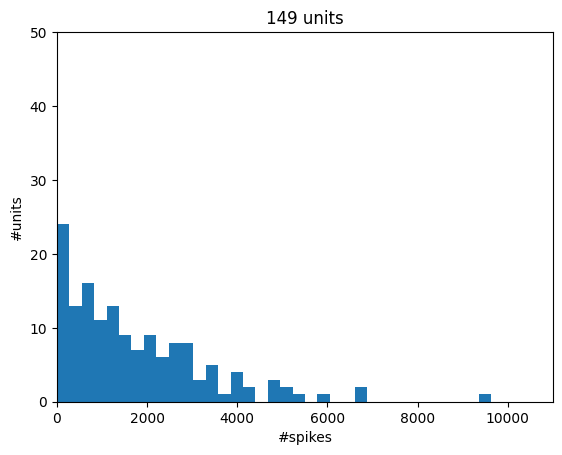

In [104]:
# (optional) Run: plot nums spikes distribution
prop_signal = SpikeSorter(RECORDING, "RT-Sort", units=prop_intermerged_units)
prop_signal.plot_nums_spikes()

In [94]:
# Run: Detect spikes in TESTING_FRAMES
def job(unit):
    spike_train = detect_spikes(unit, time_frame=TESTING_FRAMES)
    unit.spike_train = spike_train
    return unit

prop_units = []
with Pool(processes=20) as pool:
    idx = 0 
    for unit in tqdm(pool.imap(job, prop_intermerged_units), total=len(prop_intermerged_units)):
        if len(unit.spike_train) > 0:
            unit.spike_train = fix_isi_viols(unit.spike_train)
            unit.recording = RECORDING
            unit.idx = idx
            idx += 1
            prop_units.append(unit)

100%|██████████| 147/147 [00:12<00:00, 11.46it/s]


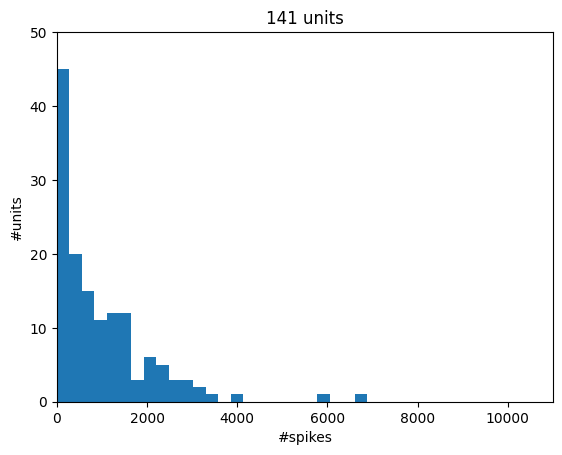

In [95]:
# Run: store units in prop_signal
prop_signal = SpikeSorter(RECORDING, "RT-Sort", units=prop_units)
prop_signal.plot_nums_spikes()

In [ ]:
# SAVE_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/231011/spike_times.npy")
# np.save(SAVE_PATH, prop_signal.get_spike_times())

In [193]:
# (optional) Run: Save prop_signal as .pickle

# recording cannot be pickled
# prop_signal.recording = None
# for unit in prop_signal:
#     unit.recording = None

# with open(f"/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/231025/prop_signal.pickle", "wb") as f:
#     pickle.dump(prop_signal, f, pickle.HIGHEST_PROTOCOL)
    
# # Set recording back
# prop_signal.recording = RECORDING
# for unit in prop_signal:
#     unit.recording = RECORDING

### Look at some merges

In [ ]:
merge = Merge(prop_pre_intermerged_units[15], prop_pre_intermerged_units[16], get_merge_elecs(prop_pre_intermerged_units[15].root_elec))
print(merge.score_latencies())
print(merge.score_rel_amps())

In [ ]:
# Look at some merges
ind = [15, 16]
##
amp_kwargs = None
for idx in ind:
    unit = prop_pre_intermerged_units[idx]
    unit.recording = RECORDING
    
    print(len(unit.spike_train))
    if amp_kwargs is None:
        amp_kwargs, prob_kwargs = plot_elec_probs(unit)
    else:
        plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

### Testing

In [195]:
len(set(merges[0].spike_train).intersection(merges[1].spike_train))

1734

100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


2725


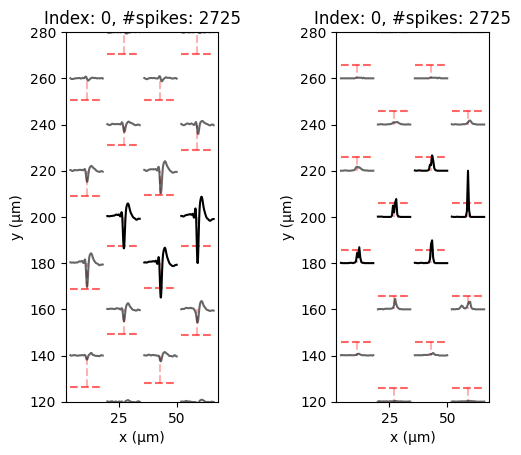

3192


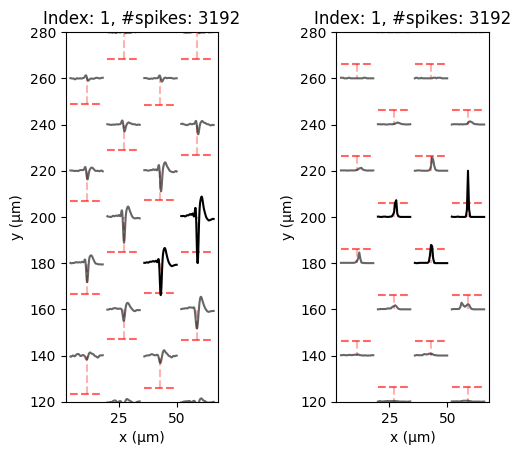

1086


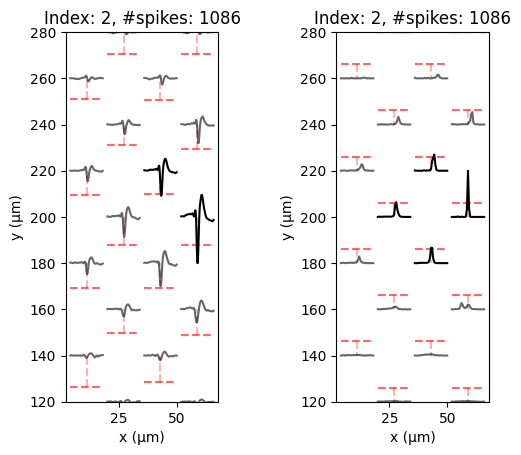

2254


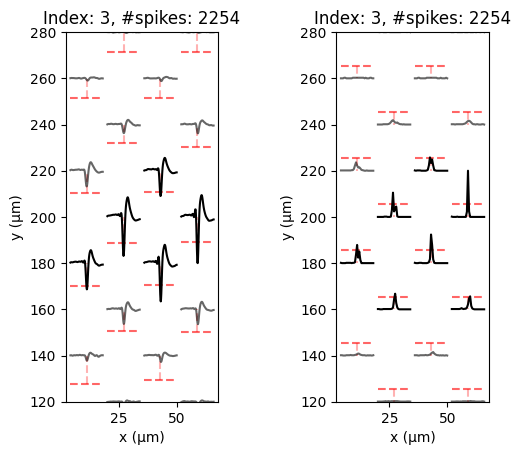

529


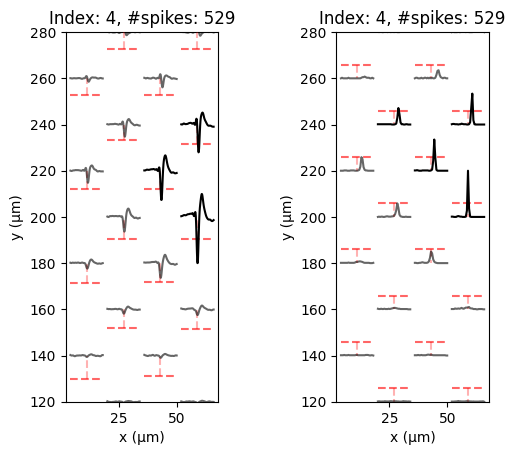

1797


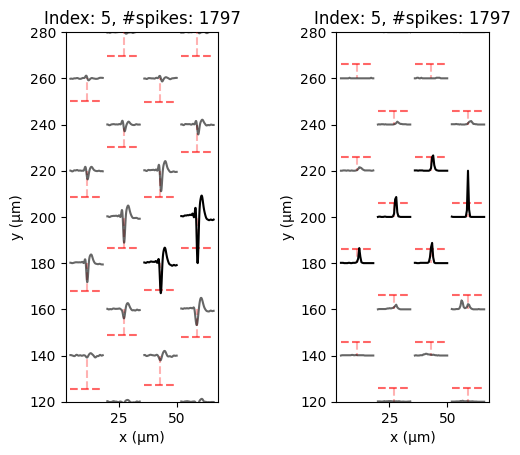

1922


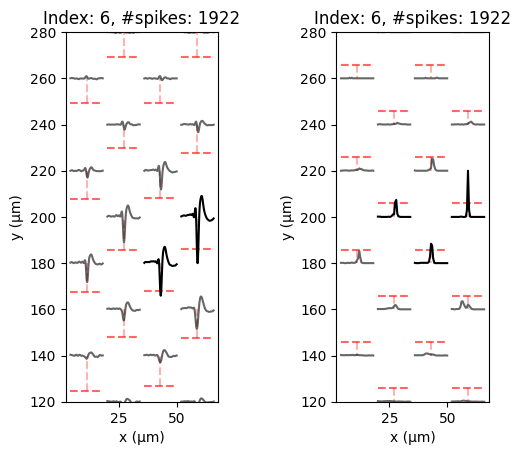

5016


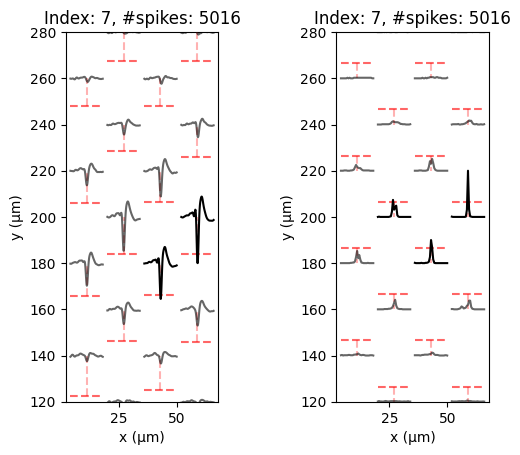

384


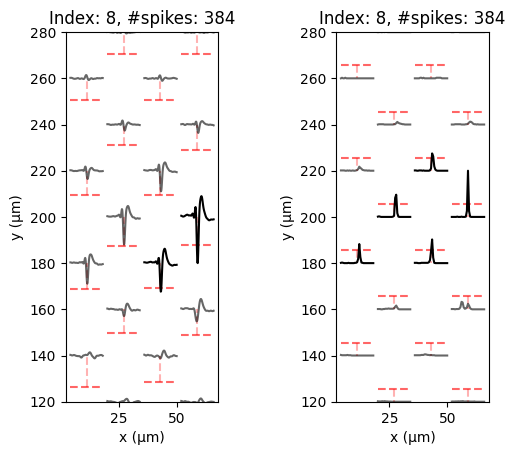

714


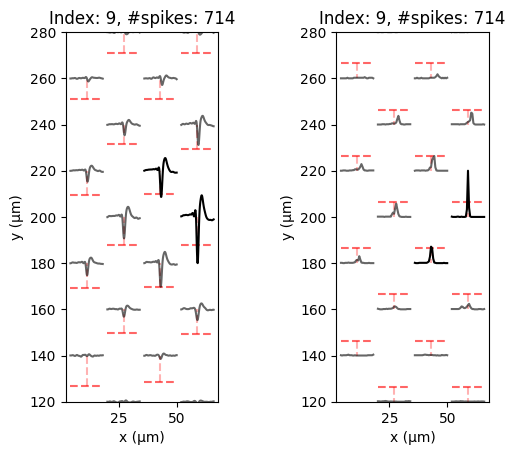

423


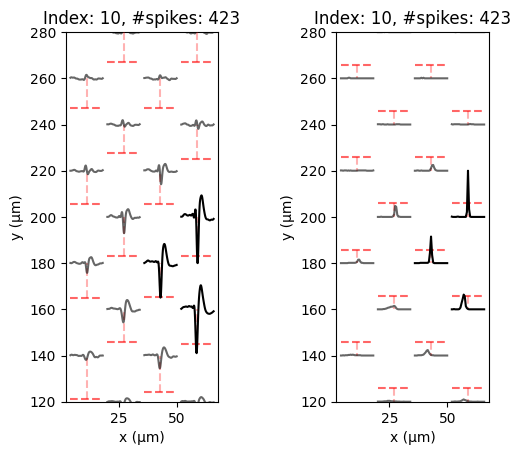

1606


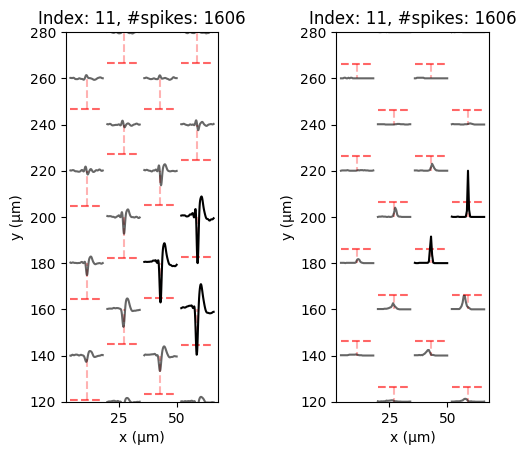

In [ ]:
# Plot clusters
elec_clusters = all_coc_clusters
for cluster in elec_clusters:
    cluster.root_elec = root_elec
# elec_clusters = all_coc_clust

# setup_coc_clusters(elec_clusters)

# for cluster in elec_clusters:
#     all_elec_probs = extract_detection_probs(cluster)
#     elec_probs = np.mean(all_elec_probs, axis=0)
    
#     cluster.latencies = np.argmax(elec_probs, axis=1) - elec_probs.shape[1]//2
#     cluster.all_elec_probs = all_elec_probs
#     cluster.elec_probs = elec_probs
#     cluster.elecs = np.flatnonzero(np.max(elec_probs, axis=1)>=prob_thresh)

units = []
def get_unit_templates(cluster_idx):
    cluster = elec_clusters[cluster_idx]
    unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.root_elec, recording=RECORDING)
    return cluster_idx, unit.get_templates(ms_before=2, ms_after=2)

with Pool(processes=20) as pool:
    tasks = range(len(elec_clusters))
    for cluster_idx, templates in tqdm(pool.imap(get_unit_templates, tasks), total=len(tasks)):
        cluster = elec_clusters[cluster_idx]
        unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.root_elec, recording=RECORDING)
        unit.templates = templates
        units.append(unit)
# Plot
# kwargs = None
# for i, unit in enumerate(units):
#     print(len(unit.spike_train))
#     if kwargs is None:
#         kwargs = unit.plot(chans_rms=CHANS_RMS)
#     else:
#         kwargs = unit.plot(**kwargs) 
#     plt.show()

# Plot with detection probabilities

amp_kwargs = None
for i, unit in enumerate(units):
    amp_kwargs = None
    elec_probs = np.mean(extract_detection_probs(elec_clusters[i]), axis=0)  # elec_clusters[i].elec_probs # 
    
    # print(f"comp elec: {19}, loc={elec_locs[19]}")
    # print(f"comp elec: {elec_clusters[i].elec}, loc={elec_locs[elec_clusters[i].elec]}")
    print(len(unit.spike_train))
    if amp_kwargs is None:
        amp_kwargs, prob_kwargs = plot_elec_probs(unit, elec_probs)
    else:
        plot_elec_probs(unit, elec_probs, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()
    
    # Plot latency histogram
    # plt.hist([c[0]*30 for c in elec_clusters[i].cocs], bins=91)
    # plt.show()

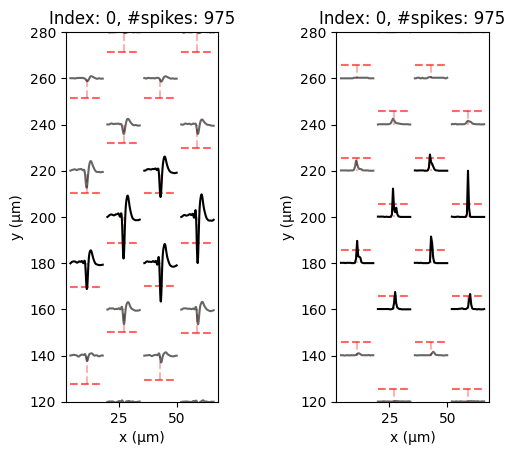

In [203]:
unit = Unit(0, list(set(merges[0].spike_train).difference(merges[1].spike_train)), root_elec, RECORDING)
plot_elec_probs(unit)
plt.show()

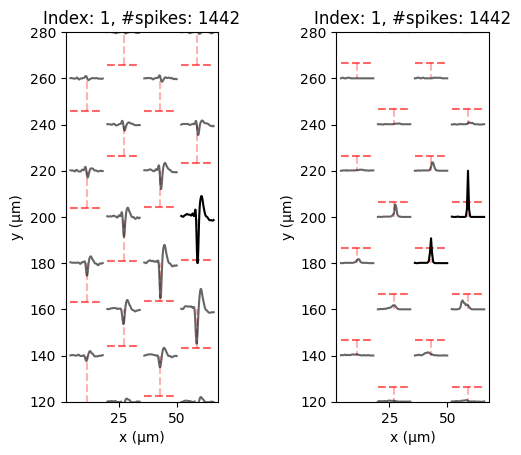

In [207]:
unit = Unit(1, list(set(merges[1].spike_train).difference(merges[0].spike_train)), root_elec, RECORDING)
plot_elec_probs(unit)
plt.show()

In [206]:
len(set(merges[10].spike_train).intersection(merges[11].spike_train))

398

#### Improve merging by looking at roots on each electrode

In [ ]:
# Need to have task be a single unit since elecs have different number of roots (task cannot be all roots on an elec)
def get_unit(task):
    elec, idx, root = task
    
    unit = Unit(idx=idx, spike_train=root.spike_train, channel_idx=root.elecs[0], recording=RECORDING)    
    unit.set_templates()
    unit.recording = None  # h5py objects cannot be pickled
    return elec, unit

elecs_units = [[] for _ in range(len(all_roots_with_footprints))]
with Pool(processes=20) as pool:
    tasks = []
    for e, roots in enumerate(all_roots_with_footprints):
        for i, root in enumerate(roots):
            tasks.append((e, i, root))
            
    for elec, unit in tqdm(pool.imap(get_unit, tasks), total=len(tasks)):
        unit.recording = RECORDING
        elecs_units[elec].append(unit)        

100%|██████████| 299/299 [01:40<00:00,  2.98it/s]


In [ ]:
for i, unit in enumerate(units[:5]):
    print(len(unit))
    # display(elec_clusters[i].df)
    unit.plot(chans_rms=CHANS_RMS)
    # if kwargs is None:
    #     kwargs = unit.plot(chans_rms=CHANS_RMS)
    # else:
    #     unit.plot(**kwargs)
    
    plt.show()

### New idea to form propagations - dead end
This method: form clusters based on which electrodes coactivate
Problem with this method: electrode latencies and relative amplitudes are not accounted for.

In [ ]:
ref_elec=17
max_elec_dist=100
min_cocs=300
time_frame=(0, 5*60*1000)
##

coc_dict = load_coc_dict(ref_elec)
if time_frame is not None:
    start_ms, end_ms = time_frame
    new_coc_dict = {}
    for (root_time, root_amp), cocs in coc_dict.items():
        if start_ms <= root_time <= end_ms:
            new_cocs = []
            for elec, time, amp in cocs:
                if start_ms <= time <= end_ms:
                    new_cocs.append((elec, time, amp))
            if len(new_cocs) > 0:
                new_coc_dict[(root_time, root_amp)] = new_cocs
    coc_dict = new_coc_dict

coc_patterns = {}
for (ref_time, ref_amp), cocs in tqdm(coc_dict.items(), total=len(coc_dict)):
    elecs = []
    filt_cocs = []
    for c in cocs:
        if calc_elec_dist(ref_elec, c[0]) <= 150:
            filt_cocs.append(c)           
            elecs.append(c[0])
    elecs = tuple(sorted(elecs))
    if elecs not in coc_patterns:
        coc_patterns[elecs] = filt_cocs
    else:
        coc_patterns[elecs] += filt_cocs
filt_coc_patterns = {elecs: cocs for elecs, cocs in coc_patterns.items() if len(cocs) >= min_cocs}

  0%|          | 0/8230 [00:00<?, ?it/s]

100%|██████████| 8230/8230 [00:00<00:00, 15546.56it/s]


In [ ]:
filt_coc_patterns[list(filt_coc_patterns.keys())[0]]

In [ ]:
all_spike_trains = []
for cocs in filt_coc_patterns.values():
    all_spike_trains.append([c[1] for c in cocs])
    
units = []
for i, (elecs, cocs) in enumerate(filt_coc_patterns.items()):
    unit = Unit(i, [c[1] for c in cocs], ref_elec, RECORDING)
    unit.elecs = elecs
    units.append(unit)

In [ ]:
# Plot clusters
def extract_templates(idx):
    unit = units[idx]
    return idx, unit.get_templates(), extract_detection_probs(unit)

with Pool(processes=12) as pool:
    for idx, templates, elec_probs in tqdm(pool.imap(extract_templates, range(len(all_spike_trains))), total=len(all_spike_trains)):
        units[idx].templates = templates
        units[idx].elec_probs = elec_probs
        
# Plot with detection probabilities
amp_kwargs = None
for i, unit in enumerate(units):
    amp_kwargs = None    
    print(len(unit.spike_train), unit.elecs)
    if amp_kwargs is None:
        amp_kwargs, prob_kwargs = plot_elec_probs(unit, unit.elec_probs)
    else:
        plot_elec_probs(unit, unit.elec_probs, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

In [ ]:
amp_kwargs = None
for i, unit in enumerate(units):
    amp_kwargs = None    
    print(len(unit.spike_train), unit.elecs)
    if amp_kwargs is None:
        amp_kwargs, prob_kwargs = plot_elec_probs(unit, unit.elec_probs)
    else:
        plot_elec_probs(unit, unit.elec_probs, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

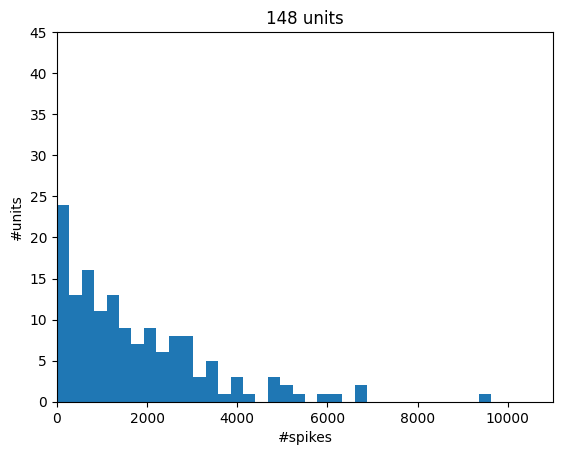

In [32]:
prop_signal = SpikeSorter(RECORDING, "RT-Sort", units=prop_intermerged_units)
plt.title(f"{len(prop_signal)} units")
plt.hist([len(spike_train) for spike_train in prop_signal.get_spike_times()], bins=40, range=(0, 11000))
plt.xlim(0, 11000)
plt.ylim(0, 45)
plt.xlabel("#spikes")
plt.ylabel("#units")
plt.show()

In [237]:
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231022/spike_times.npy", prop_signal.get_spike_times())

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


### Testing

In [ ]:
prop_a = prop_signal[53]
prop_b = prop_signal[54]

In [82]:
merge = Merge(prop_a, prop_b, get_merge_elecs(prop_a.chan))
print(merge.score_latencies())
print(merge.score_rel_amps())

0.9869270324707031
0.35658848


1651


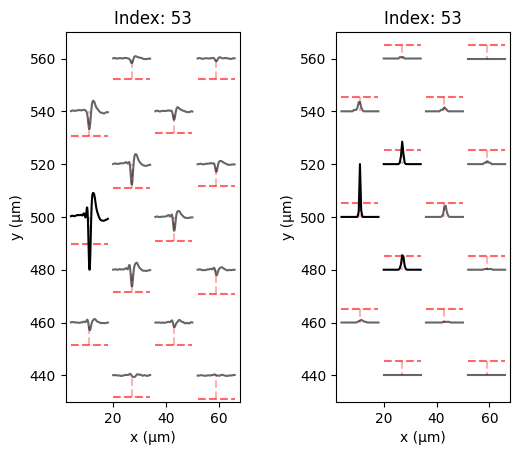

1666


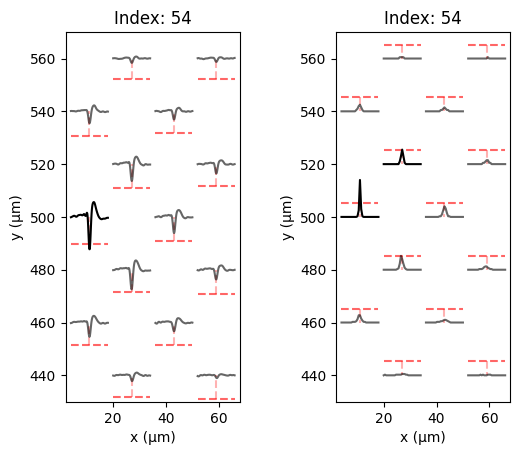

In [84]:
amp_kwargs = None
for unit in [prop_a, prop_b]:
    print(len(unit.spike_train))
    if amp_kwargs is None:
        amp_kwargs, prob_kwargs = plot_elec_probs(unit)
    else:
        plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

In [86]:
print(len(set(prop_a.spike_train).intersection(prop_b.spike_train)))
print(len(prop_a.spike_train), len(prop_b.spike_train))

184
1651 1666


In [374]:
units = [prop_signal[0], prop_signal[1]]
setup_coc_clusters(units)
merge = Merge(units[0], units[1], get_merge_elecs(0))
print(merge.score_latencies())
print(merge.score_rel_amps())

0.12902069091796875
0.048466966


1761


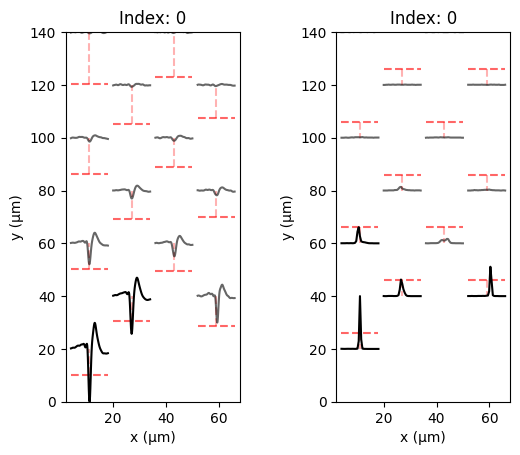

2973


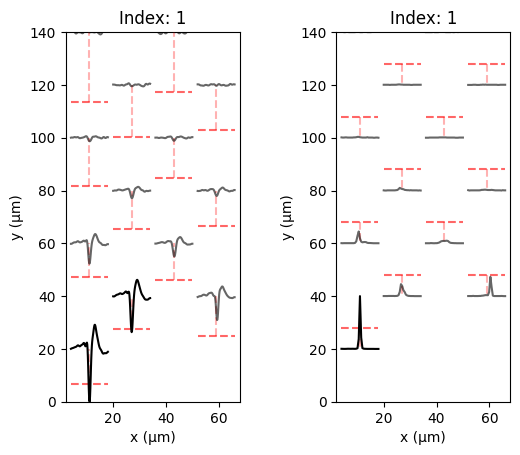

In [373]:
for unit in units:
    print(len(unit.spike_train))
    plot_elec_probs(unit)
    plt.show()

2339


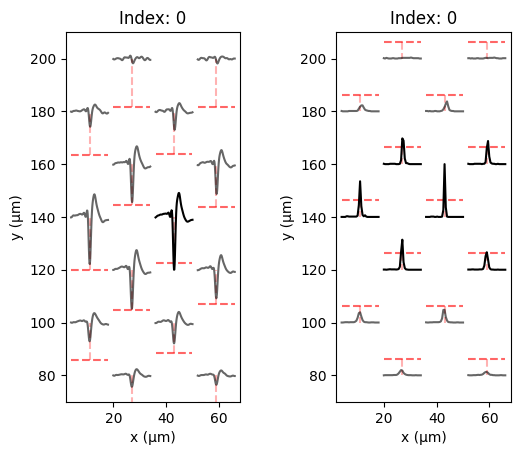

In [269]:
# Compare detected spikes to backbone
print(len(spike_train))
unit = Unit(0, spike_train, coc_cluster.root_elec, RECORDING)
plot_elec_probs(unit, np.mean(extract_detection_probs(unit), axis=0))
plt.show()

print(f"Backbone")
print(len(coc_cluster.spike_train))
unit = Unit(0, coc_cluster.spike_train, coc_cluster.root_elec, RECORDING)
plot_elec_probs(unit, np.mean(extract_detection_probs(unit), axis=0))
plt.show()

In [ ]:
# SAVE_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/231011/spike_times.npy")
# np.save(SAVE_PATH, prop_signal.get_spike_times())

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Comparison with kilosort

### Just kilosort

In [74]:
"""
time_frame:
    If not None, only use coocurrences between time_frame[0]ms to time_frame[1]ms (inclusive, inclusive)
    If None, use all cooccurrences
"""

# kilosort = Kilosort(utils.PATH_SM4_SI, "first", RECORDING)
kilosort = get_experts_kilosort()
# kilosort.plot_nums_spikes(show=False, bins=20)
# plt.xlim(0, 25000)
# plt.show()

detect_spikes_time_frame = TESTING_FRAMES
if detect_spikes_time_frame is not None:
    start_ms, end_ms = detect_spikes_time_frame
    spike_times = []
    for times in kilosort.get_spike_times():
        times_ind = start_ms <= times
        times_ind *= times <= end_ms
        spike_times.append(times[times_ind])
        
    kilosort = SpikeSorter(
        RECORDING,
        name="Experts Kilosort",
        spike_times=spike_times
    )

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/data/MEAprojects/PropSignal/src/comparison.py:334: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)
/data/MEAprojects/PropSignal/src/sorters/kilosort.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

Recording does not have scaled traces. Setting gain to 0.195


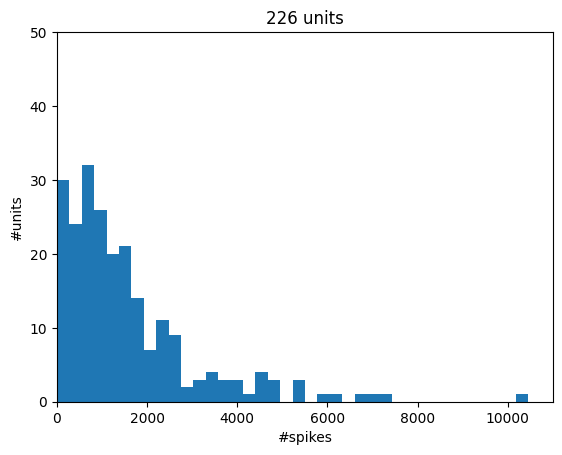

In [108]:
kilosort.plot_nums_spikes()

/data/MEAprojects/PropSignal/src/comparison.py:336: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  match_counts = np.zeros((n, m), dtype=int)


Num RT-Sort: 149
Num Experts Kilosort: 226
Num single matches: 24

For RT-Sort:
Num max matches: 24
Num unique max matches: 24

For Experts Kilosort:
Num max matches: 25
Num unique max matches: 24


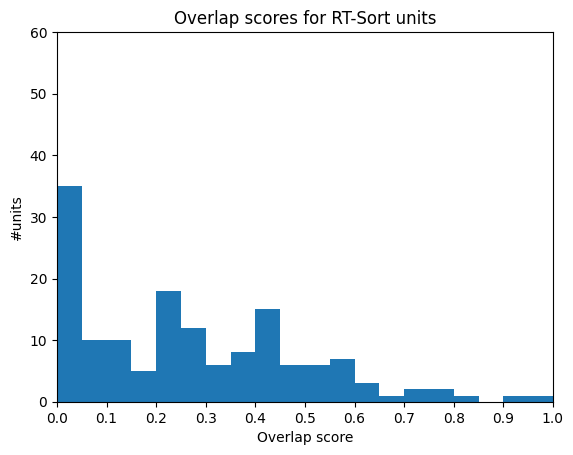

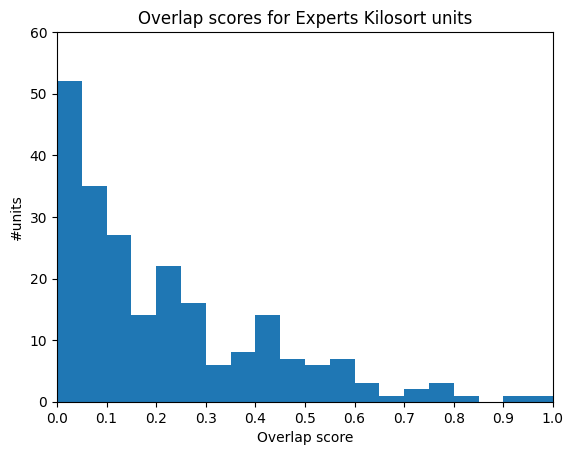

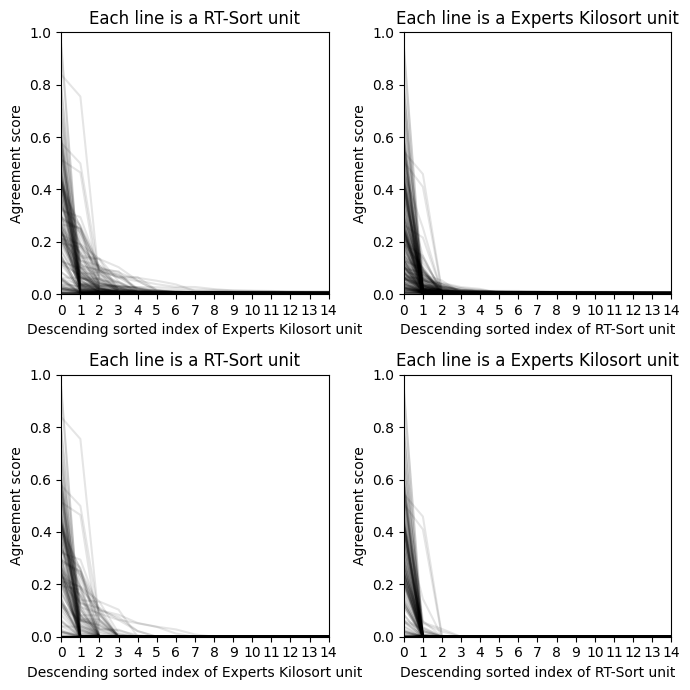

/data/MEAprojects/PropSignal/src/comparison.py:336: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  match_counts = np.zeros((n, m), dtype=int)


Num RT-Sort: 149
Num Experts Kilosort: 226
Num single matches: 56

For RT-Sort:
Num max matches: 64
Num unique max matches: 54

For Experts Kilosort:
Num max matches: 59
Num unique max matches: 54


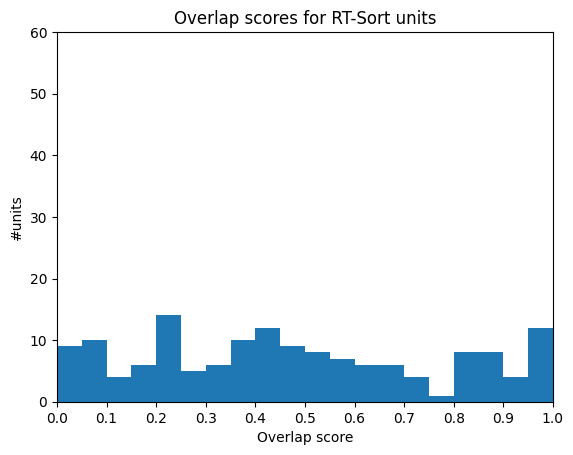

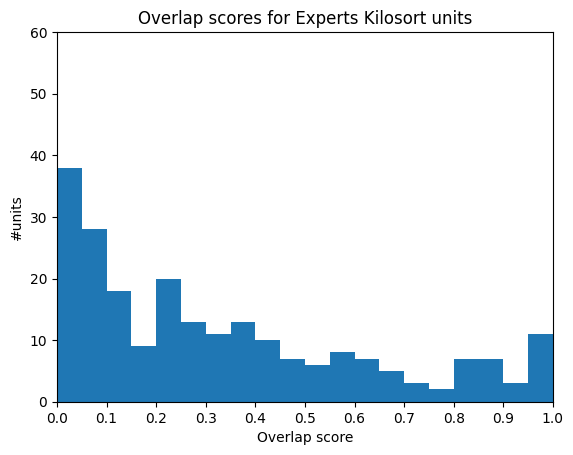

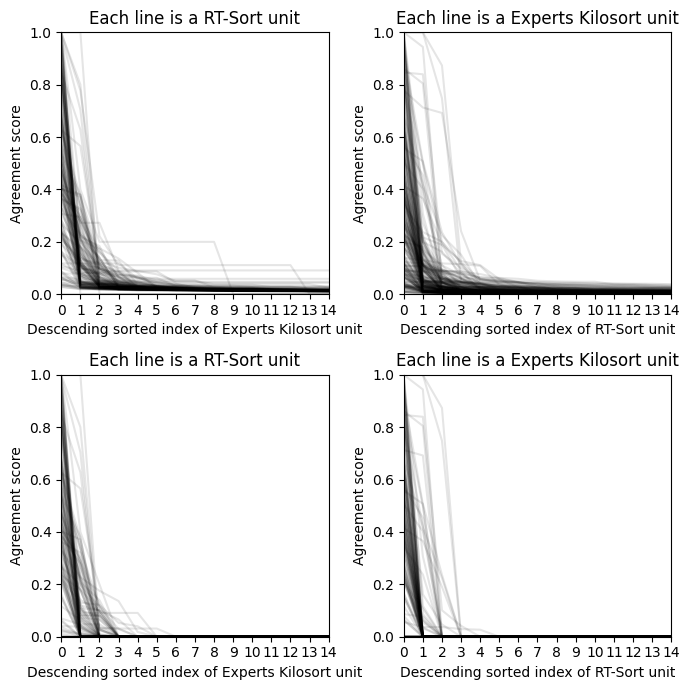

/data/MEAprojects/PropSignal/src/comparison.py:336: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  match_counts = np.zeros((n, m), dtype=int)


Num RT-Sort: 149
Num Experts Kilosort: 226
Num single matches: 70

For RT-Sort:
Num max matches: 71
Num unique max matches: 70

For Experts Kilosort:
Num max matches: 107
Num unique max matches: 70


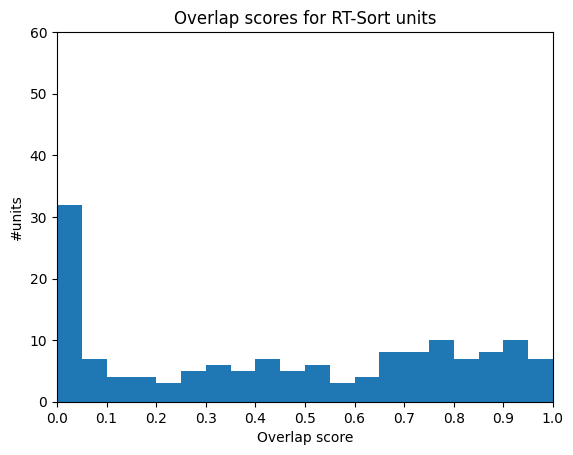

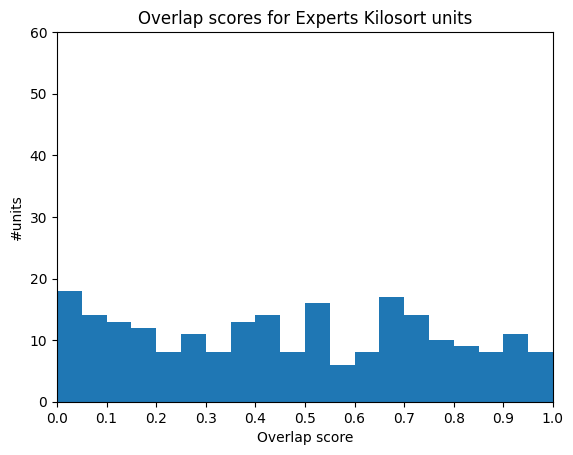

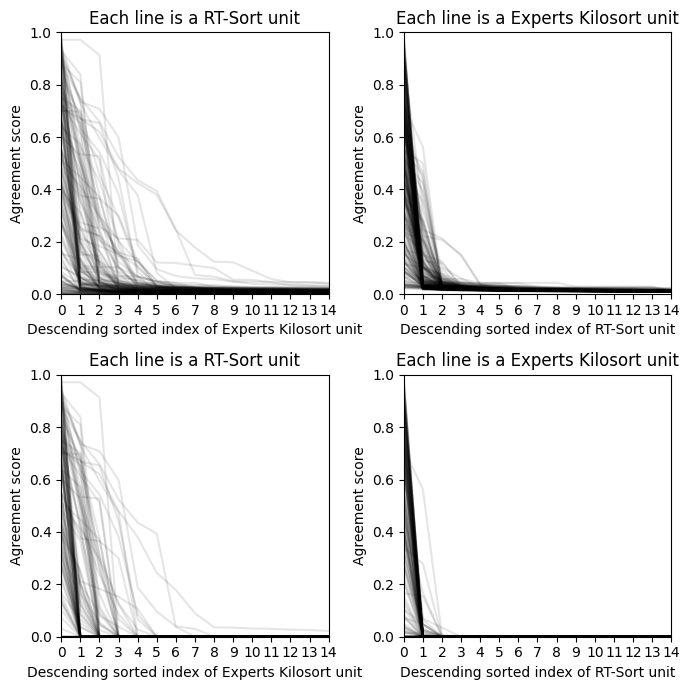

In [106]:
comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5, delta_time=0.4)
comp_1_5.summary()
comp_1_5.plot_line_comps()

comp_1 = Comparison(prop_signal, kilosort, score_formula=1, delta_time=0.4)
comp_1.summary()
comp_1.plot_line_comps()

comp_2 = Comparison(prop_signal, kilosort, score_formula=2, delta_time=0.4)
comp_2.summary()
comp_2.plot_line_comps()

In [116]:
comp_1_5.agreement_scores.shape

(149, 226)

1.5


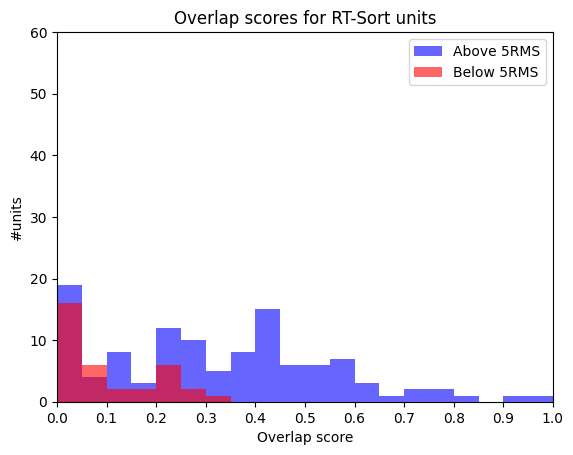

1


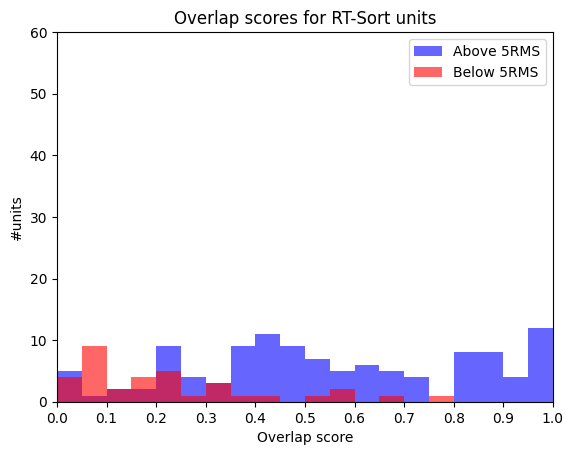

2


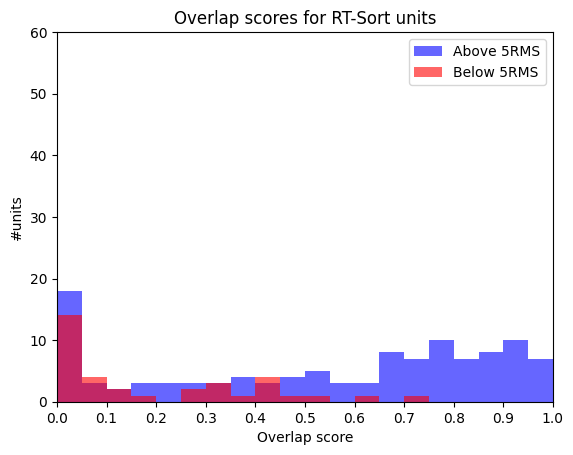

114 above 5RMS, 35 below 5RMS


In [129]:
for comp in (comp_1_5, comp_1, comp_2): 
    print(comp.score_formula)
    scores_above = []  # Overlap scores for units above 5RMS
    scores_below = []  # Overlap scores for units fully below 5RMS
    for idx, unit in enumerate(prop_signal):
        chans_above = unit.mean_amps >= CHANS_RMS * 5
        scores = comp.agreement_scores[idx, :]
        score = np.max(scores)
        if np.sum(chans_above) > 0:
            scores_above.append(score)
        else:
            scores_below.append(score)
    
    plt.title(f"Overlap scores for RT-Sort units")
    plt.hist(scores_above, range=(0, 1), bins=20, alpha=0.6, color="blue", label="Above 5RMS")
    plt.hist(scores_below, range=(0, 1), bins=20, alpha=0.6, color="red", label="Below 5RMS")
    
    plt.xlabel("Overlap score")
    plt.xticks([x/10 for x in range(11)])
    plt.ylabel("#units")
    plt.xlim(0, 1)
    plt.ylim(0, 60)
    plt.legend()
    plt.show()
print(f"{len(scores_above)} above 5RMS, {len(scores_below)} below 5RMS")

In [130]:
prop_train = set()
for spike_train in prop_signal.get_spike_times():
    prop_train.update(spike_train)
prop_train = np.sort(list(prop_train))
    
ks_train = set()
for spike_train in kilosort.get_spike_times():
    ks_train.update(spike_train)
ks_train = np.sort(list(ks_train))

num_matches = Comparison.count_matching_events(prop_train, ks_train,
                                               delta=0.4)
print(f"#spikes:")
print(f"Matches: {num_matches}")
print(f"RT-Sort: {len(prop_train)}, {num_matches/len(prop_train)*100:.1f}")
print(f"Kilosort: {len(ks_train)}, {num_matches/len(ks_train)*100:.1f}")

#spikes:
Matches: 193083
RT-Sort: 248400, 77.7
Kilosort: 347992, 55.5


### Ignore prop units fully below 5RMS

108


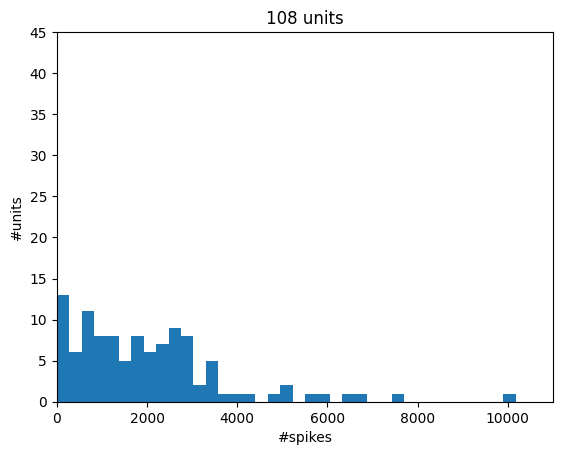

In [162]:
prop_units_above_5rms = []
for unit in prop_signal:
    chans_above = unit.mean_amps >= CHANS_RMS * 5
    if sum(chans_above) > 0:
        prop_units_above_5rms.append(unit)
print(len(prop_units_above_5rms))

prop_signal = SpikeSorter(RECORDING, "RT-Sort", units=prop_units_above_5rms)
plt.title(f"{len(prop_signal)} units")
plt.hist([len(spike_train) for spike_train in prop_signal.get_spike_times()], bins=40, range=(0, 11000))
plt.xlim(0, 11000)
plt.ylim(0, 45)
plt.xlabel("#spikes")
plt.ylabel("#units")
plt.show()

/data/MEAprojects/PropSignal/src/comparison.py:334: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)


Num RT-Sort: 108
Num Experts Kilosort: 226
Num single matches: 22

For RT-Sort:
Num max matches: 22
Num unique max matches: 22

For Experts Kilosort:
Num max matches: 23
Num unique max matches: 22


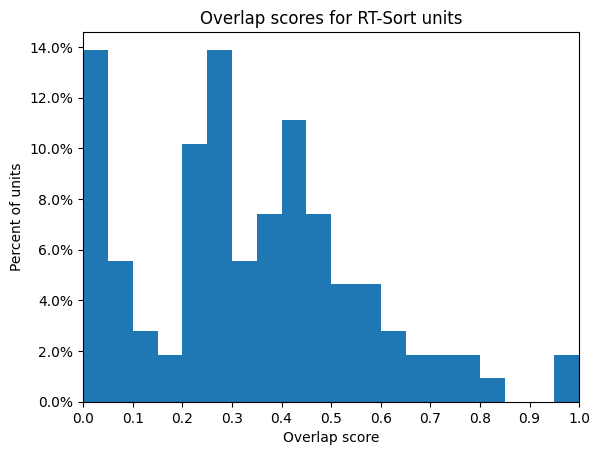

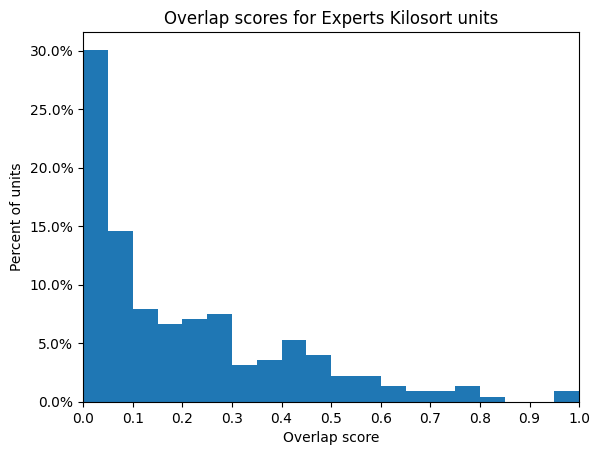

Num RT-Sort: 108
Num Experts Kilosort: 226
Num single matches: 45

For RT-Sort:
Num max matches: 49
Num unique max matches: 44

For Experts Kilosort:
Num max matches: 48
Num unique max matches: 44


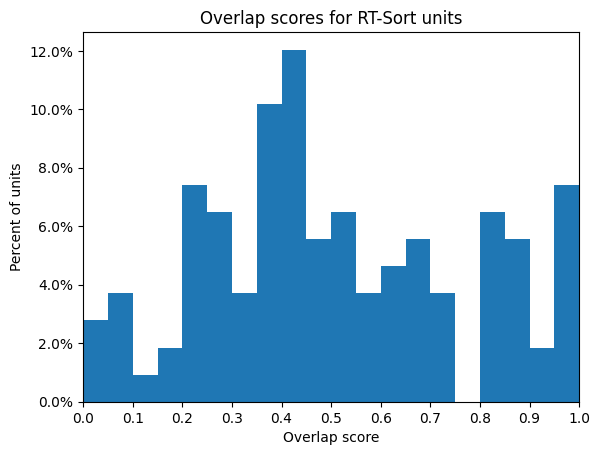

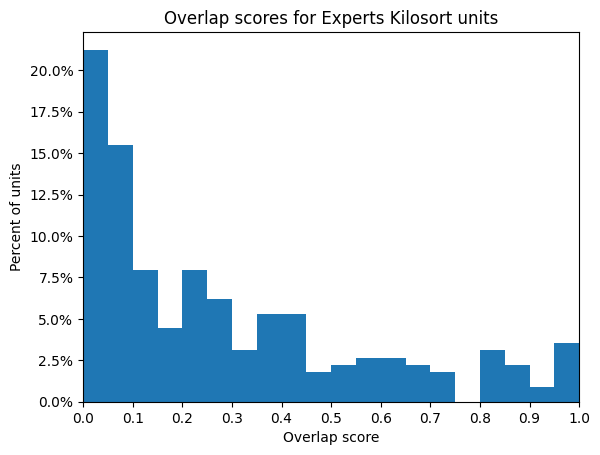

Num RT-Sort: 108
Num Experts Kilosort: 226
Num single matches: 69

For RT-Sort:
Num max matches: 70
Num unique max matches: 68

For Experts Kilosort:
Num max matches: 107
Num unique max matches: 68


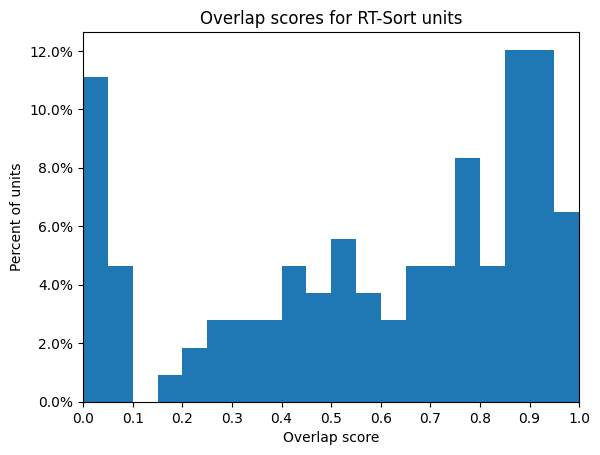

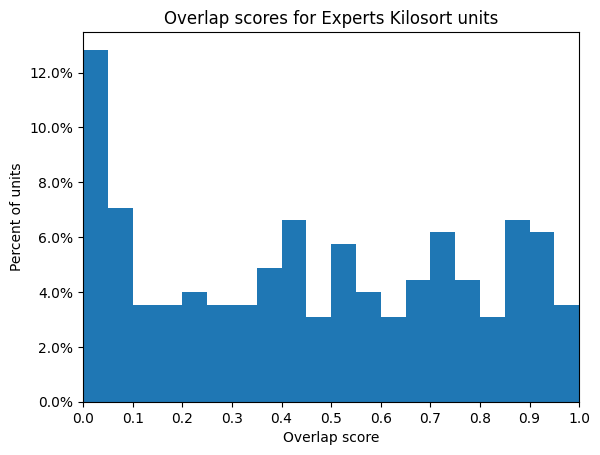

In [163]:
comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5, delta_time=0.4)
comp_1_5.summary()

comp_1 = Comparison(prop_signal, kilosort, score_formula=1, delta_time=0.4)
comp_1.summary()

comp_2 = Comparison(prop_signal, kilosort, score_formula=2, delta_time=0.4)
comp_2.summary()

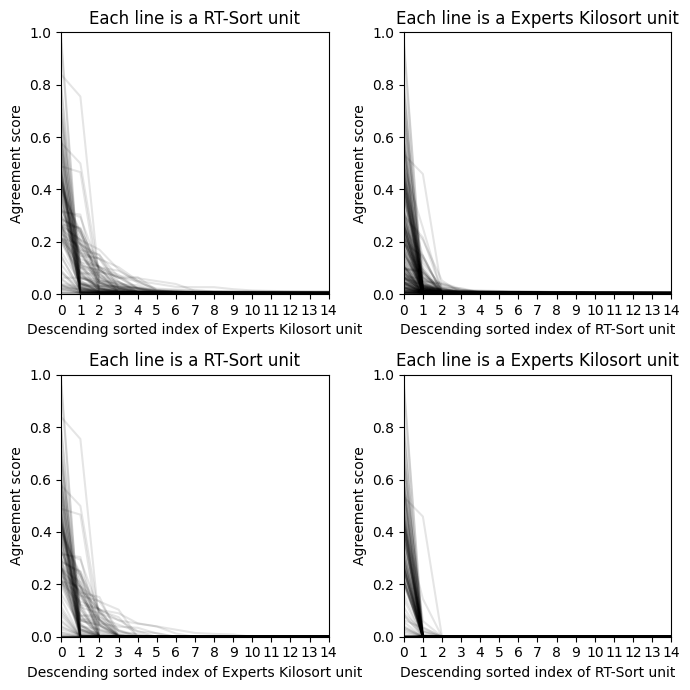

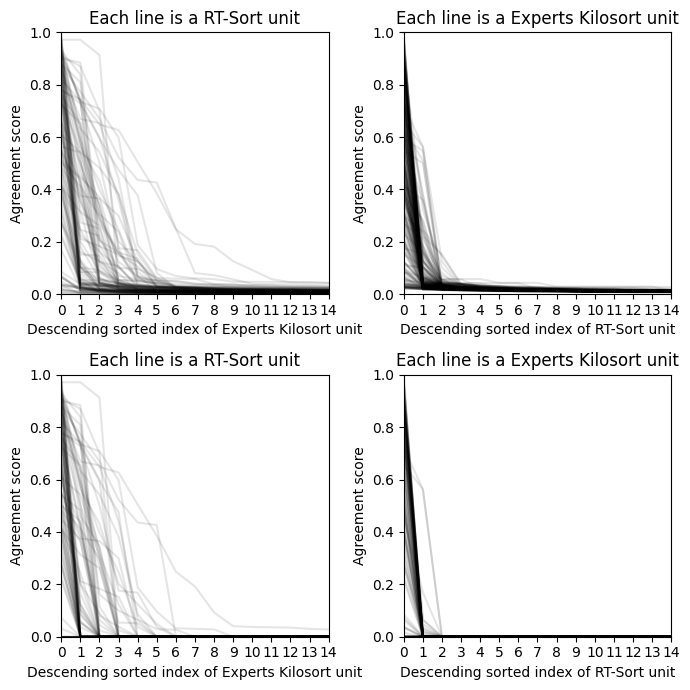

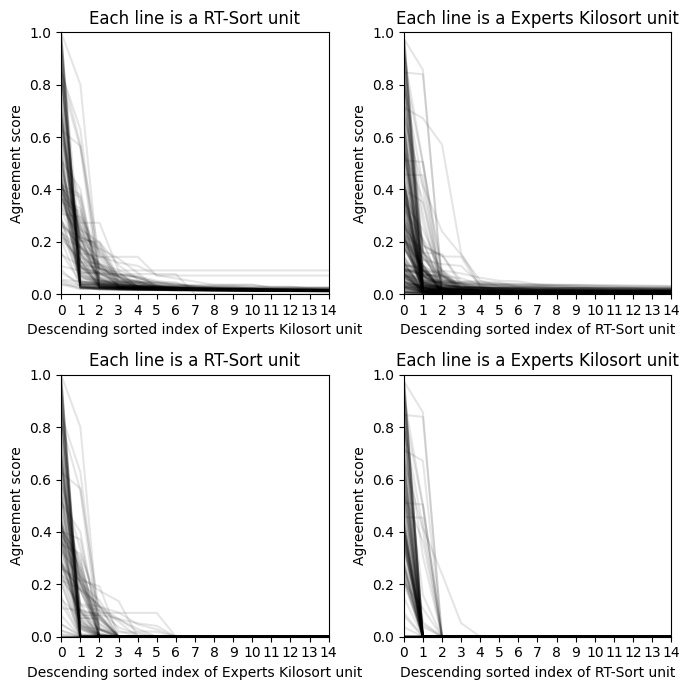

In [165]:
comp_1_5.plot_line_comps()
comp_2.plot_line_comps()
comp_1.plot_line_comps()

In [164]:
prop_train = set()
for spike_train in prop_signal.get_spike_times():
    prop_train.update(spike_train)
prop_train = np.sort(list(prop_train))
    
ks_train = set()
for spike_train in kilosort.get_spike_times():
    ks_train.update(spike_train)
ks_train = np.sort(list(ks_train))

num_matches = Comparison.count_matching_events(prop_train, ks_train,
                                               delta=0.4)
print(f"#spikes:")
print(f"Matches: {num_matches}")
print(f"RT-Sort: {len(prop_train)}, {num_matches/len(prop_train)*100:.1f}")
print(f"Kilosort: {len(ks_train)}, {num_matches/len(ks_train)*100:.1f}")

#spikes:
Matches: 173947
RT-Sort: 209660, 83.0
Kilosort: 347992, 50.0


### Look at prop units' surrounding ks units

In [ ]:
# Create all_ks_units with self.templates and self.chan set
all_ks_units = []

def job(idx):
    unit = Unit(idx, all_ks_spike_times[idx], -1, RECORDING)
    templates = unit.get_templates()
    unit.recording = None
    unit.chan = np.argmin(np.min(templates, axis=1))
    return unit

all_ks_spike_times = kilosort.get_spike_times()
with Pool(processes=20) as pool:
    tasks = range(len(all_ks_spike_times))
    for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
        unit.recording = RECORDING
        all_ks_units.append(unit)

100%|██████████| 226/226 [01:22<00:00,  2.75it/s]


In [ ]:
# Create elec_to_ks_units
elec_to_ks_units = {}
for ks_unit in all_ks_units:
    if ks_unit.chan not in elec_to_ks_units:
        elec_to_ks_units[ks_unit.chan] = [ks_unit]
    else:
        elec_to_ks_units[ks_unit.chan].append(ks_unit)

In [ ]:
UNITS = []
THRESH = 0.1  # Look at units with score below this

for p in range(len(prop_signal)):
    agreement_scores = comp_2.agreement_scores[p, :]
    score = np.max(agreement_scores)
    if score < THRESH:
        # print(score)
        UNITS.append(prop_signal[p])

print(len(UNITS))

0.0641958967571145
0.03670745272525028
0.013888888888888888
0.018518518518518517
0.03763277693474962
0.028963414634146343
0.005972696245733789
0.034482758620689655
0.06568848758465011
0.015145848915482424
0.006024096385542169
0.03455019556714472
0.08535536052314575
0.07196969696969698
0.04782608695652174
0.064
0.021739130434782608
17


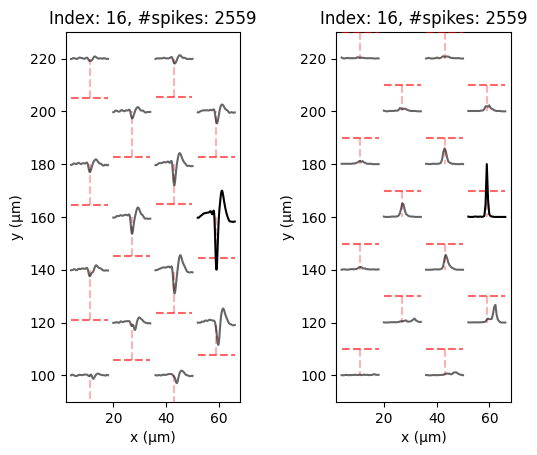

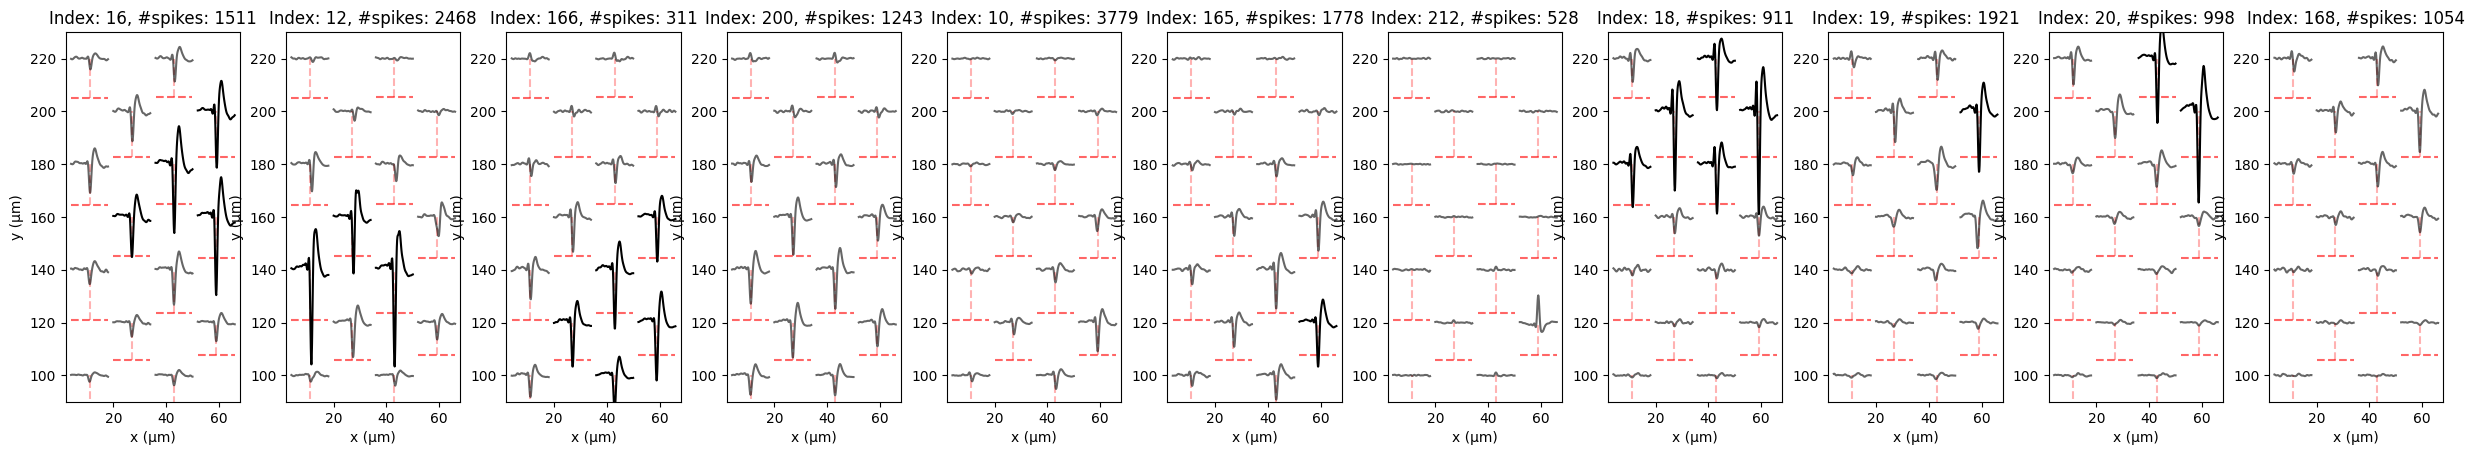

In [ ]:
# Plot ks units on all elecs with 50um and four units with highest overlap score
for unit in UNITS:
    elecs = get_merge_elecs(unit.chan, 50)
    ks_units = []
    for elec in elecs:
        if elec in elec_to_ks_units:
            ks_units += elec_to_ks_units[elec]
    
    kwargs, _ = plot_elec_probs(unit)
    plt.show()
        
    fig, axes = plt.subplots(ncols=len(ks_units), figsize=(2.8*len(ks_units), 4.8))
    for i, unit in enumerate(ks_units):
        unit.plot(axis=axes[i], **kwargs)
    plt.show()
    break

### Look at kilosort units with the same max match
For #matches/#kilosort

In [133]:
# Create all_ks_units with self.templates and self.chan set --> Don't run this if already ran before
all_ks_units = []

def job(idx):
    unit = Unit(idx, all_ks_spike_times[idx], -1, RECORDING)
    templates = unit.get_templates()
    unit.templates = templates
    unit.recording = None
    unit.chan = np.argmin(np.min(templates, axis=1))
    return unit

all_ks_spike_times = kilosort.get_spike_times()
with Pool(processes=20) as pool:
    tasks = range(len(all_ks_spike_times))
    for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
        unit.recording = RECORDING
        all_ks_units.append(unit)

100%|██████████| 226/226 [01:27<00:00,  2.59it/s]


In [199]:
# Create prop_to_ks_units
prop_to_ks_units = {}  # {prop_unit: (score, ks_unit)}
for k, ks_unit in enumerate(kilosort):
    scores = comp_2.agreement_scores[:, k]
    max_p = np.argmax(scores)
    score = scores[max_p]
    ks_tuple = (score, ks_unit)
    
    prop = prop_signal[max_p]
    if prop not in prop_to_ks_units:
        prop_to_ks_units[prop] = [ks_tuple]
    else:
        prop_to_ks_units[prop].append(ks_tuple)

In [ ]:
# Plot ks units on all elecs with 50um and four units with highest overlap score
min_prop_units = 2  # Only look at 
replot_dist = 100 # Replot ks unit if chan far away from prop unit
#

for prop, ks_tuples in prop_to_ks_units.items():
    if len(ks_tuples) < min_prop_units:
        continue
    
    print("-"*50)
    kwargs, _ = plot_elec_probs(prop)
    plt.show()
        
    fig, axes = plt.subplots(ncols=len(ks_tuples), figsize=(2.8*len(ks_tuples), 4.8))
    replot_units = []  # Replot unit if chan far away from prop unit
    for i, (score, unit) in enumerate(ks_tuples):
        print(f"Unit {unit.idx}: {score}")        
        unit.plot(axis=axes[i], **kwargs)
        if calc_elec_dist(unit.chan, prop.chan) > replot_dist:
            replot_units.append(unit)
    plt.show()
    
    if len(replot_units) > 0:
        fig, axes = plt.subplots(ncols=len(replot_units), figsize=(2.8*len(replot_units), 4.8))
        axes = np.atleast_1d(axes)
        for i, unit in enumerate(replot_units):
            unit.plot(axis=axes[i], chans_rms=CHANS_RMS)
        plt.show()
    

#### Merge kilosort units
Merge kilosort units that have the same max prop unit
This is the upper bound of kilosort merging

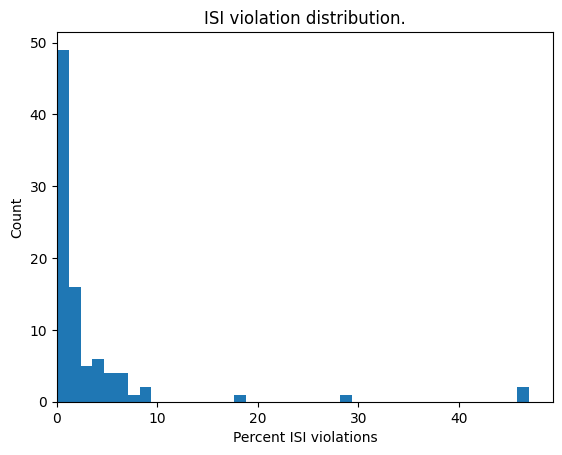

In [224]:
all_uppermerged_ks_spike_times = []
for ks_tuples in prop_to_ks_units.values():
    spike_train = []
    for score, ks_unit in ks_tuples:
        spike_train.extend(ks_unit.spike_train)
    spike_train = np.sort(spike_train)  
    # spike_train = fix_isi_viols(spike_train)
    all_uppermerged_ks_spike_times.append(spike_train)
uppermerged_kilosort = SpikeSorter(RECORDING, "Uppermerged Kilosort", all_uppermerged_ks_spike_times)
_ = uppermerged_kilosort.plot_isis(bins=40)

Num RT-Sort: 108
Num Uppermerged Kilosort: 91
Num single matches: 20

For RT-Sort:
Num max matches: 20
Num unique max matches: 20

For Uppermerged Kilosort:
Num max matches: 20
Num unique max matches: 20


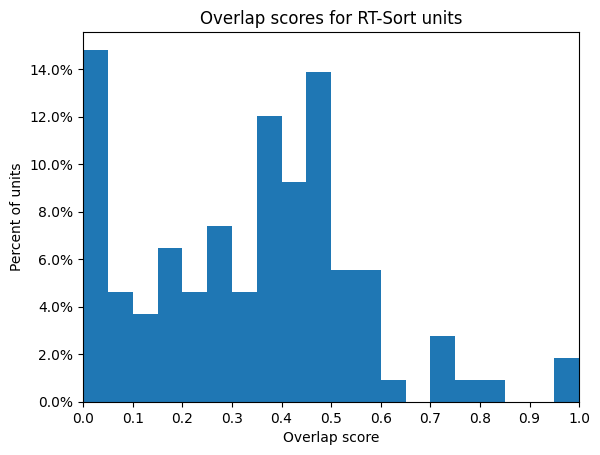

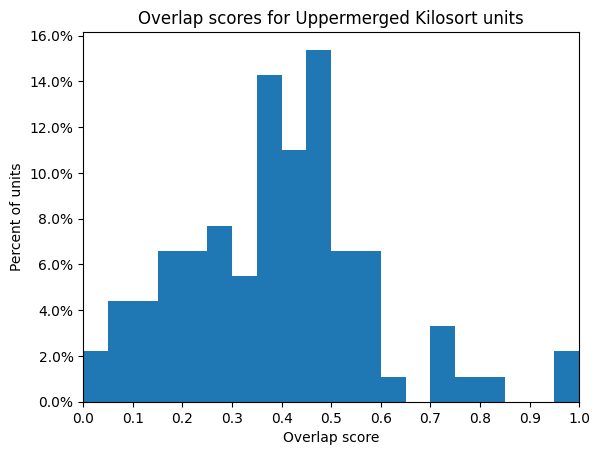

Num RT-Sort: 108
Num Uppermerged Kilosort: 91
Num single matches: 65

For RT-Sort:
Num max matches: 108
Num unique max matches: 57

For Uppermerged Kilosort:
Num max matches: 65
Num unique max matches: 63


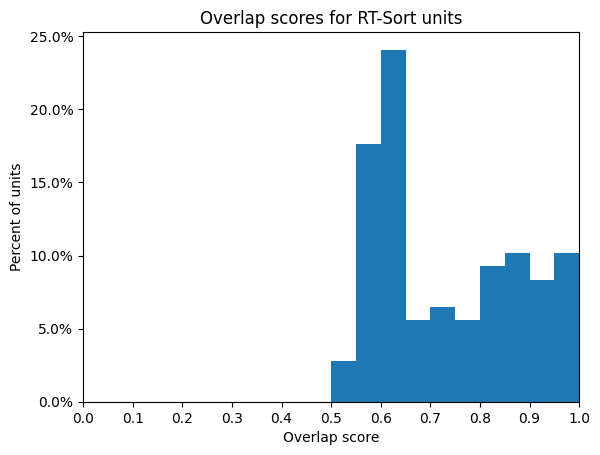

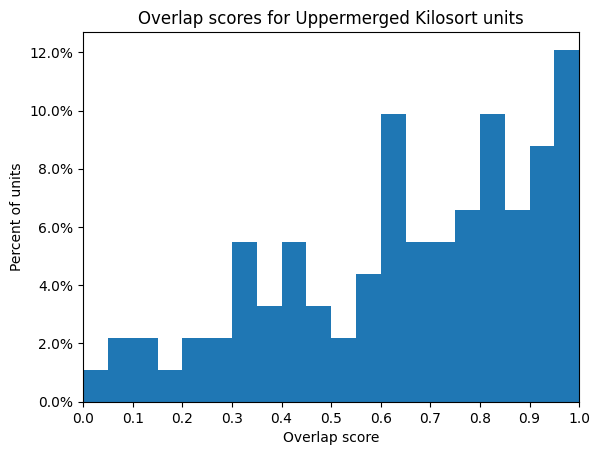

Num RT-Sort: 108
Num Uppermerged Kilosort: 91
Num single matches: 48

For RT-Sort:
Num max matches: 50
Num unique max matches: 47

For Uppermerged Kilosort:
Num max matches: 48
Num unique max matches: 48


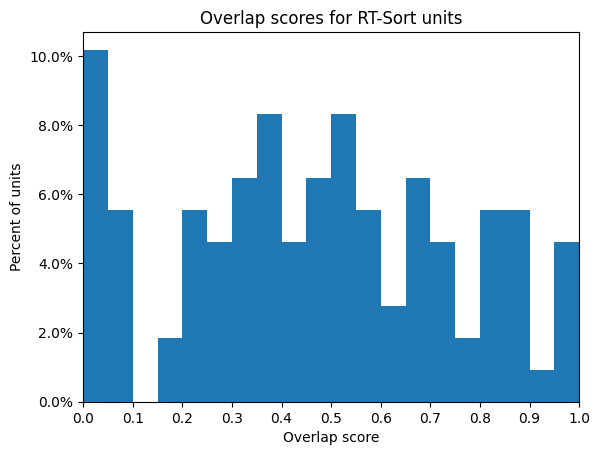

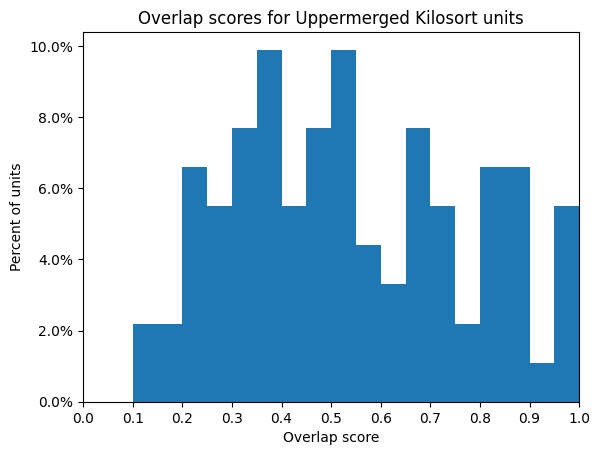

In [225]:
comp_1_5 = Comparison(prop_signal, uppermerged_kilosort, score_formula=1.5, delta_time=2)
comp_1_5.summary()

comp_1 = Comparison(prop_signal, uppermerged_kilosort, score_formula=1, delta_time=2)
comp_1.summary()

comp_2 = Comparison(prop_signal, uppermerged_kilosort, score_formula=2, delta_time=2)
comp_2.summary()

### Kilosort as prop
Assume each kilosort unit is a root that needs to be merged with other roots and detects spikes

In [279]:
# Form ks_prop units and set footprint stats for MERGING (use_rms_thresh=FALSE)

class KSProp:
    def __init__(self, spike_train) -> None:
        self.spike_train = spike_train
        
def form_ks_prop(spike_train):
    prop = KSProp(spike_train)
    set_footprint_stats(prop, use_rms_thresh=True, rel_amp_thresh=0)  # Should be false
    return prop

all_ks_props = []
with Pool(processes=20) as pool:
    kilosort_spike_times = kilosort.get_spike_times()
    for ks_prop in tqdm(pool.imap(form_ks_prop, kilosort_spike_times), total=len(kilosort_spike_times)):
        all_ks_props.append(ks_prop)

 42%|████▏     | 96/226 [00:51<01:10,  1.86it/s]


IndexError: index 31 is out of bounds for axis 2 with size 31

In [ ]:
# Look at footprint stats
for elec in all_ks_props[1].prop_elecs_:
    print(elec, [round(s, 4) for s in all_ks_props[1].footprint_stats_[elec]])

1 [0.0229, 0.0483, 2.3026, 0.5224, 5.2879]


In [ ]:
# Merge - intraGMM
elec_to_ks = {}
for ks in all_ks_props:
    # print(ks.prop_elecs_)
    
    if len(ks.prop_elecs_) > 0:
        # print(np.sort(ks.footprint_stats_[:, -1])[-3:])
        # unit = Unit(0, ks.spike_train, np.argmax(ks.footprint_stats_[:, 2]), recording)
        # unit.plot(chans_rms=chans_rms)
        # plt.show()
        
        elec = ks.prop_elecs_[0]
        if elec not in elec_to_ks:
            elec_to_ks[elec] = [ks]
        else:
            elec_to_ks[elec].append(ks)
            
all_ks_props_merged = []
for ks_props in tqdm(elec_to_ks.values()):
    if len(ks_props) == 1:
        all_ks_props_merged += ks_props
    else:
        all_ks_props_merged += merge_roots(deepcopy(ks_props))
        
# Set self.recording=None so units can be pickled
all_ks_props = []
for ks_prop in all_ks_props_merged:
    ks_prop.recording=None
    all_ks_props.append(ks_prop)
print(f"#merges: {len(all_ks_props)}")

100%|██████████| 120/120 [00:00<00:00, 1301.74it/s]

#merges: 160


In [ ]:
# Form ks_prop units and set footprint stats for DETECTING SPIKES (use_rms_thresh=TRUE)        
def job(ks_prop):
    set_footprint_stats(ks_prop, use_rms_thresh=True)
    return ks_prop

all_ks_props_spikes = []
with Pool(processes=20) as pool:
    for ks_prop in tqdm(pool.imap(job, all_ks_props), total=len(all_ks_props)):
        all_ks_props_spikes.append(ks_prop)
all_ks_props = all_ks_props_spikes

  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [01:18<00:00,  2.04it/s]


In [ ]:
# Check footprints of kilosort units
kilosort_15 = get_experts_kilosort()

for i, spike_train in enumerate(kilosort_15.get_spike_times()):    
    unit = Unit(i, spike_train, 0, recording)
    unit.set_templates(num_wfs=500)
    unit.chan = np.argmin(np.min(unit.templates, axis=1))
    unit.plot(chans_rms=chans_rms)
    plt.show()

In [ ]:
# Detect spikes
ks_prop_spike_times = []
for ks in tqdm(all_ks_props):
    if len(ks.prop_elecs_) > 1:
        spikes = detect_spikes(ks, x_std=1000, min_coc_p=0)
        if len(spikes) > 0:
            ks_prop_spike_times.append(spikes)

  7%|▋         | 11/160 [00:00<00:04, 31.63it/s]

100%|██████████| 160/160 [00:05<00:00, 26.84it/s]


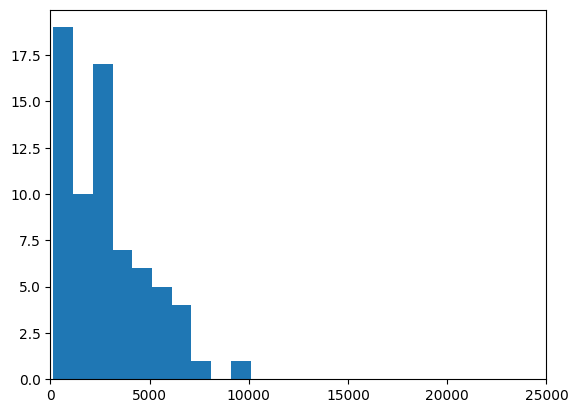

In [ ]:
kilosort_prop = DummySorter(ks_prop_spike_times, name="Kilosort Prop")
plt.hist([len(k) for k in ks_prop_spike_times])
plt.xlim(0, 25000)
plt.show()

/data/MEAprojects/PropSignal/src/comparison.py:335: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)


Num Prop: 104
Num Kilosort Prop: 70
Num single matches: 32

For Prop:
Num max matches: 34
Num unique max matches: 32

For Kilosort Prop:
Num max matches: 40
Num unique max matches: 31


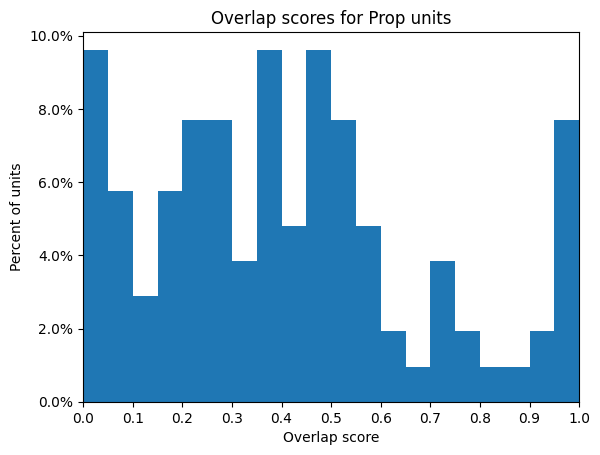

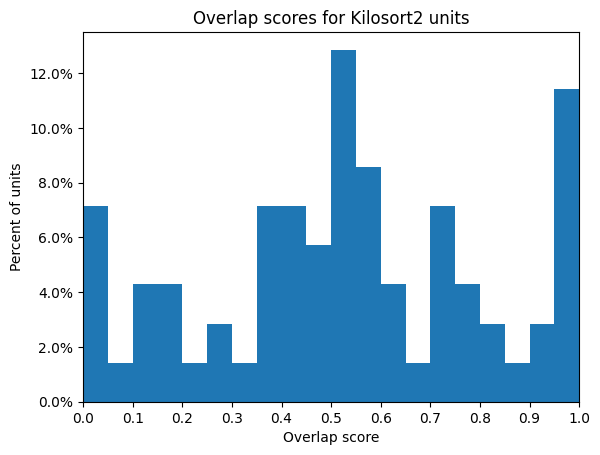

Num Prop: 104
Num Kilosort Prop: 70
Num single matches: 55

For Prop:
Num max matches: 79
Num unique max matches: 47

For Kilosort Prop:
Num max matches: 57
Num unique max matches: 46


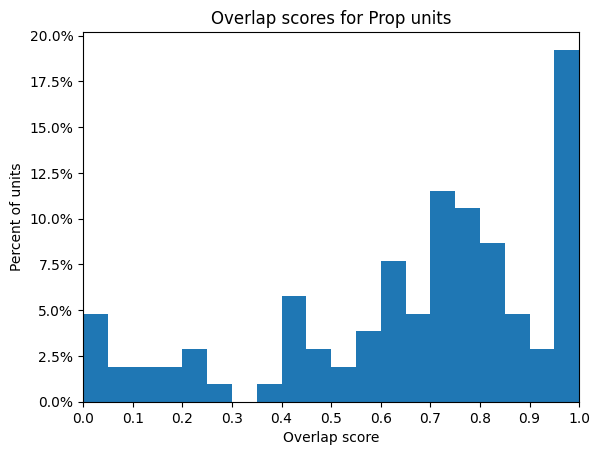

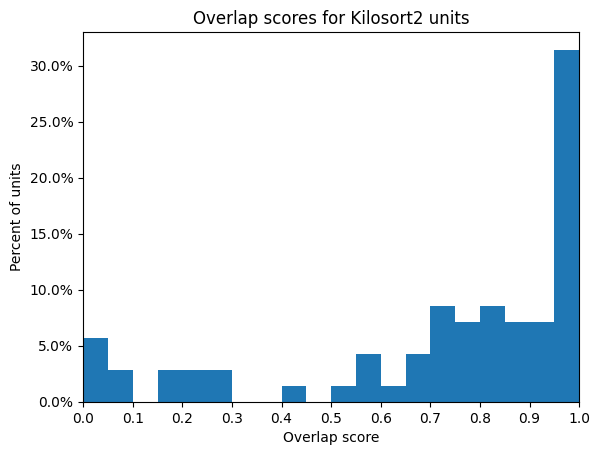

Num Prop: 104
Num Kilosort Prop: 70
Num single matches: 41

For Prop:
Num max matches: 48
Num unique max matches: 35

For Kilosort Prop:
Num max matches: 51
Num unique max matches: 34


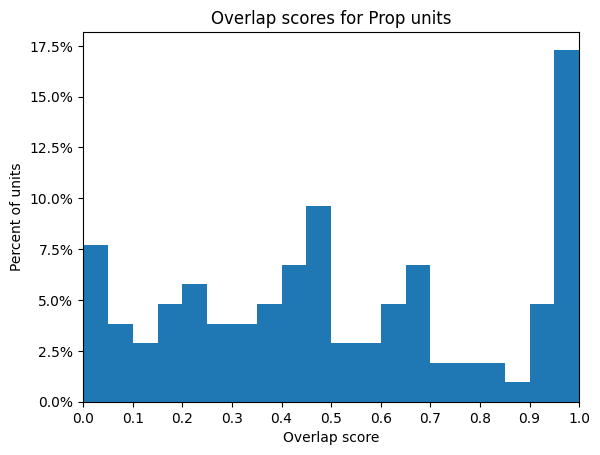

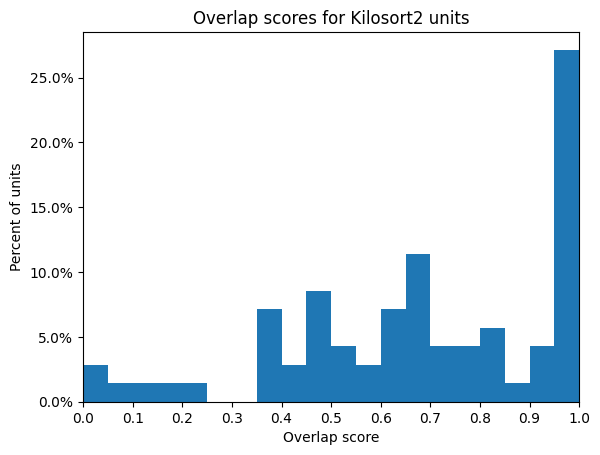

In [ ]:
comp_1_5 = Comparison(prop_signal, kilosort_prop, score_formula=1.5)
comp_1_5.summary()

comp_1 = Comparison(prop_signal, kilosort_prop, score_formula=1)
comp_1.summary()

comp_2 = Comparison(prop_signal, kilosort_prop, score_formula=2)
comp_2.summary()

### Merged kilosort

In [ ]:
# Extract mean templates for prop units

NUM_WFS = 300
MS_BEFORE = 2
MS_AFTER = 2

np.random.seed(231)
##
# Need to convert prop's units from Unit objects to PropUnit objects
prop_units = []
for idx, unit in enumerate(prop_signal):
    dataframe = []
    for elec in all_props_detected[idx].prop_elecs_:
        dataframe.append((elec, all_props_detected[idx].footprint_stats_[elec, 0], 100, 1))
    dataframe = DataFrame(dataframe, columns=["ID", "latency", "cooccurrences", "ccg_ratio"])
    dataframe = dataframe.astype({"ID": int, "latency": float, "cooccurrences": int, "ccg_ratio": float})
    prop_units.append(PropUnit([dataframe], idx, spike_train=unit.spike_train, recording=RECORDING))

def extract_templates(unit_idx):
    unit = prop_units[unit_idx]
    return unit_idx, unit.get_templates(num_wfs=NUM_WFS, ms_before=MS_BEFORE, ms_after=MS_AFTER)

with Pool(processes=12) as pool:
    for unit_idx, templates in tqdm(pool.imap(extract_templates, range(len(prop_units))), total=len(prop_units)):
        prop_units[unit_idx].templates = templates
        prop_units[unit_idx].chan = np.argmin(np.min(templates, axis=1))

100%|██████████| 103/103 [00:39<00:00,  2.60it/s]


In [ ]:
# Extract mean templates for kilosort units

NUM_WFS = 300
MS_BEFORE = 2
MS_AFTER = 2

np.random.seed(231)
##
ks_units = [unit for unit in kilosort]
def extract_templates(unit_idx):
    unit = ks_units[unit_idx]
    return unit_idx, unit.get_templates(num_wfs=NUM_WFS, ms_before=MS_BEFORE, ms_after=MS_AFTER)

with Pool(processes=12) as pool:
    for unit_idx, templates in tqdm(pool.imap(extract_templates, range(len(ks_units))), total=len(ks_units)):
        ks_units[unit_idx].templates = templates
        ks_units[unit_idx].chan = np.argmin(np.min(templates, axis=1))

100%|██████████| 226/226 [01:21<00:00,  2.78it/s]


In [206]:
prop_units = [unit for unit in prop_signal]

In [211]:
F.grid_search_num_merges(prop_units, all_ks_units, comp_2.agreement_scores, 
                         max_isi_viol_p_values=[None, 1, 1.5, 2, 3, 4, 5, 6, 7, 8], max_wf_diff_values=[np.inf])

inf
NaN    0
1.0   36
1.5   45
2.0   51
3.0   55
4.0   59
5.0   57
6.0   57
7.0   57
8.0   57

In [212]:
merged_ks_units = F.merge_ks_units(prop_units, all_ks_units, comp_2.agreement_scores,
                                   max_isi_viol_p=2, max_wf_diff=np.inf)
sum(len(merge) for merge in merged_ks_units if len(merge) > 1)
# test = [merge for merge in merged_ks_units if len(merge) > 1]

51

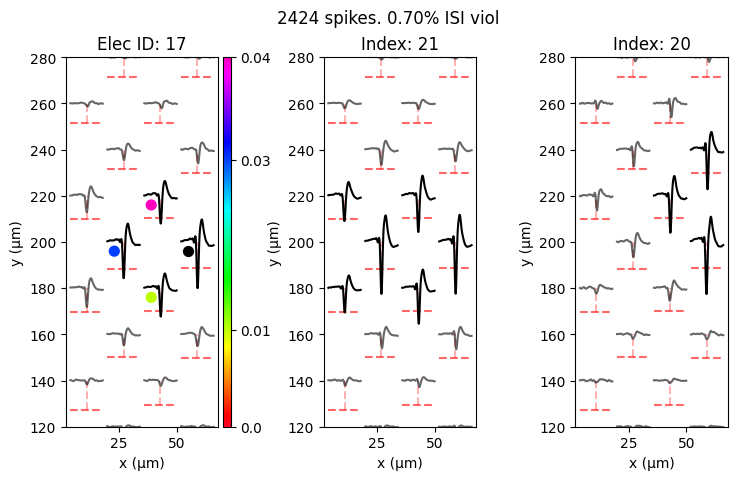

% ISI violations for each unit



Waveform dissimilarity for each unit pair


21   20
21  -1  187
20  -1   -1

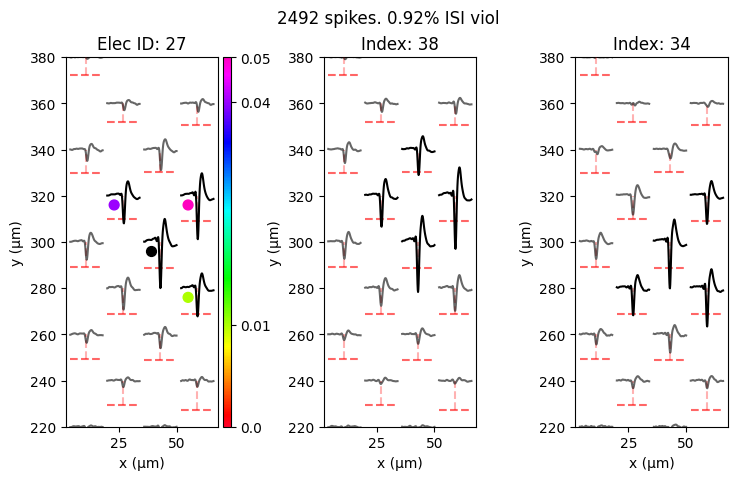

% ISI violations for each unit



Waveform dissimilarity for each unit pair


38   34
38  -1  177
34  -1   -1

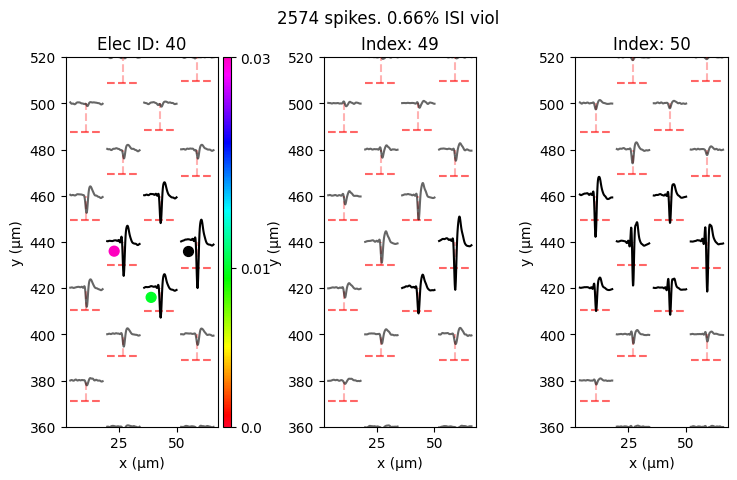

% ISI violations for each unit



Waveform dissimilarity for each unit pair


49   50
49  -1  219
50  -1   -1

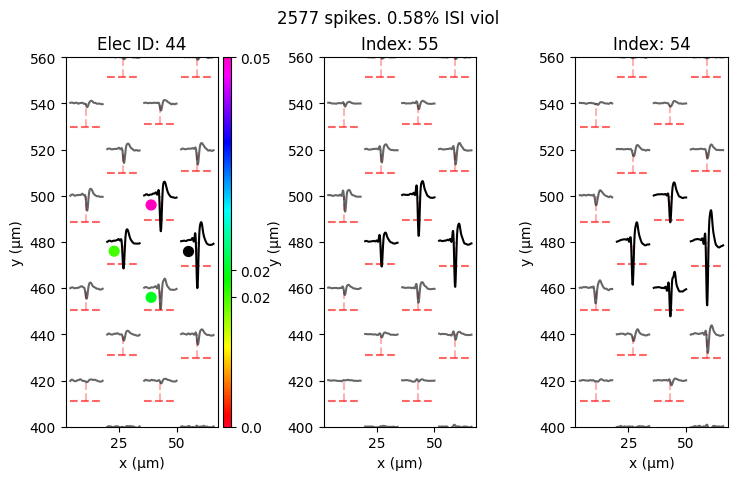

% ISI violations for each unit



Waveform dissimilarity for each unit pair


55   54
55  -1  175
54  -1   -1

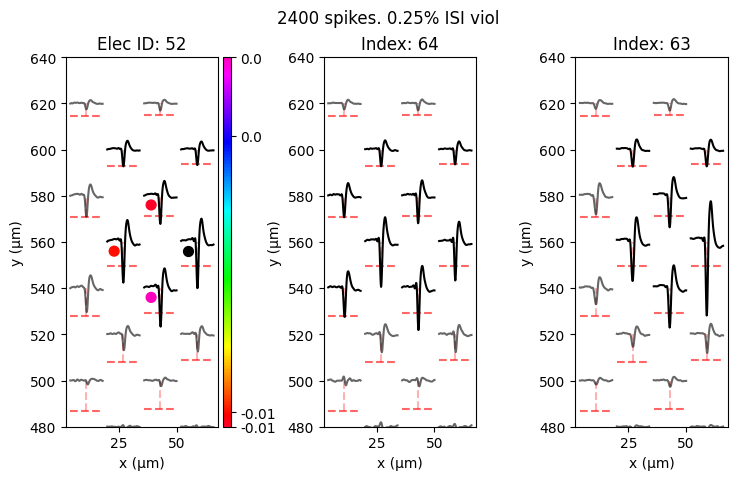

% ISI violations for each unit



Waveform dissimilarity for each unit pair


64   63
64  -1  207
63  -1   -1

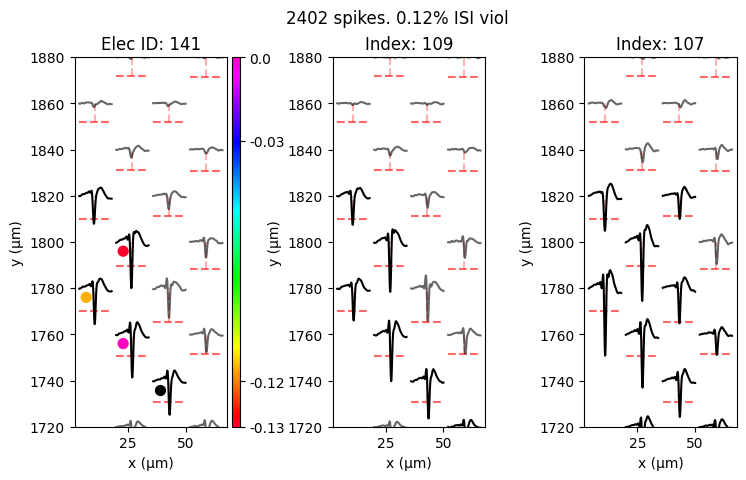

% ISI violations for each unit



Waveform dissimilarity for each unit pair


109  107
109   -1  192
107   -1   -1

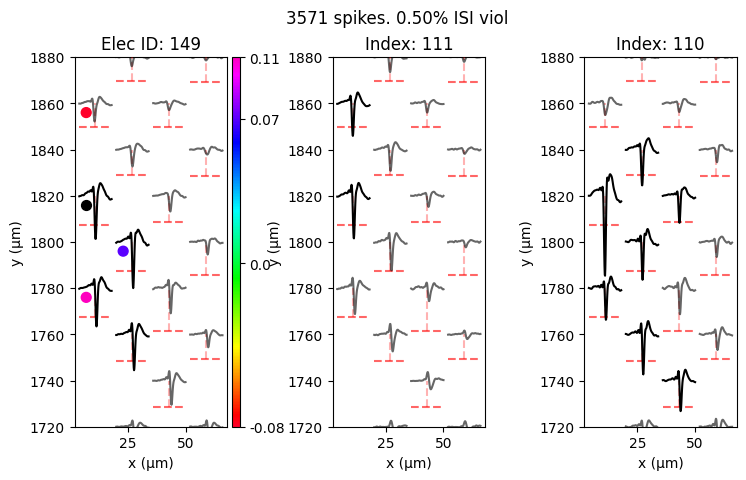

% ISI violations for each unit



Waveform dissimilarity for each unit pair


111  110
111   -1  277
110   -1   -1

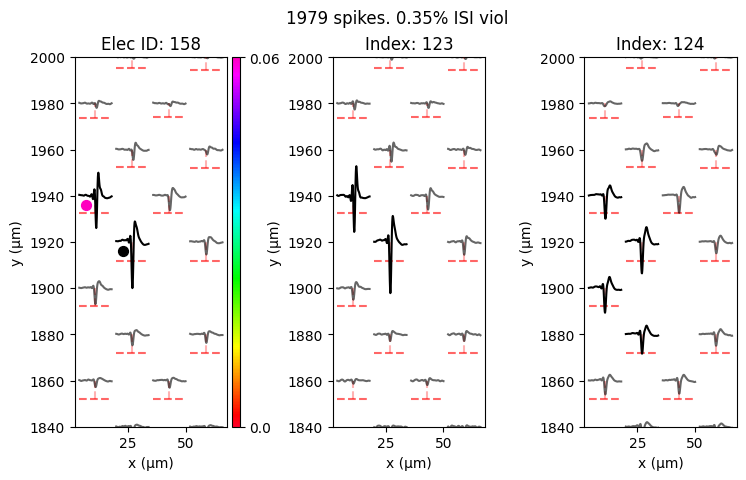

% ISI violations for each unit



Waveform dissimilarity for each unit pair


123  124
123   -1  300
124   -1   -1

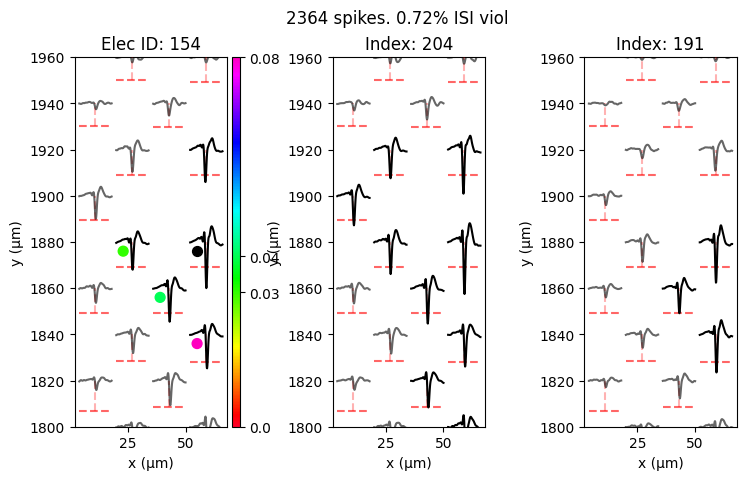

% ISI violations for each unit



Waveform dissimilarity for each unit pair


204  191
204   -1  266
191   -1   -1

In [ ]:
for merge in merged_ks_units:
    if len(merge) > 1:
        merge.plot(CHANS_RMS)

/data/MEAprojects/PropSignal/src/comparison.py:334: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)


Num RT-Sort: 108
Num Sorter: 198
Num single matches: 26

For RT-Sort:
Num max matches: 26
Num unique max matches: 26

For Sorter:
Num max matches: 27
Num unique max matches: 26


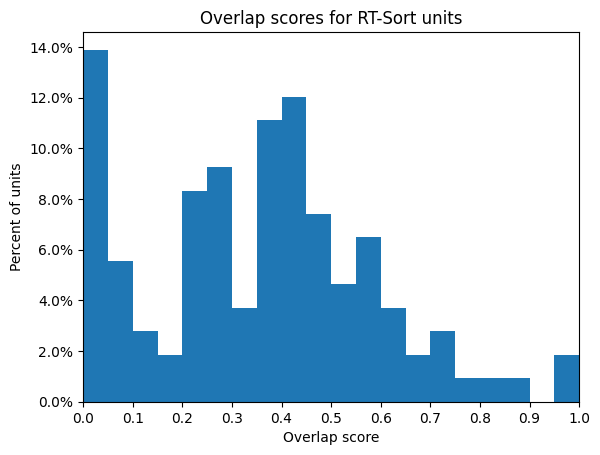

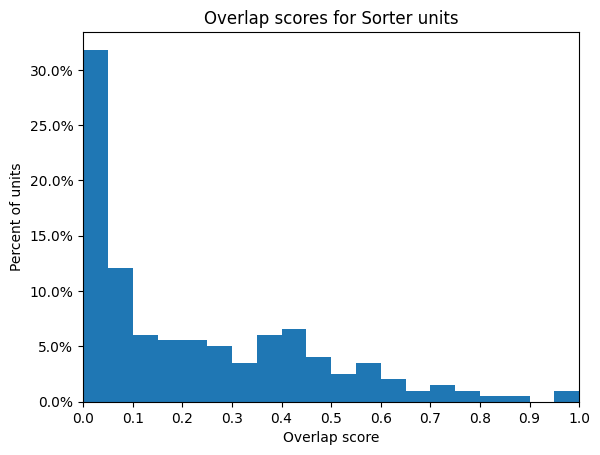

Num RT-Sort: 108
Num Sorter: 198
Num single matches: 50

For RT-Sort:
Num max matches: 55
Num unique max matches: 48

For Sorter:
Num max matches: 52
Num unique max matches: 48


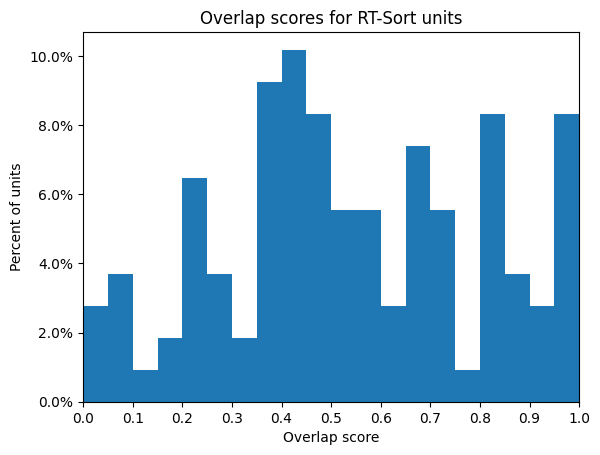

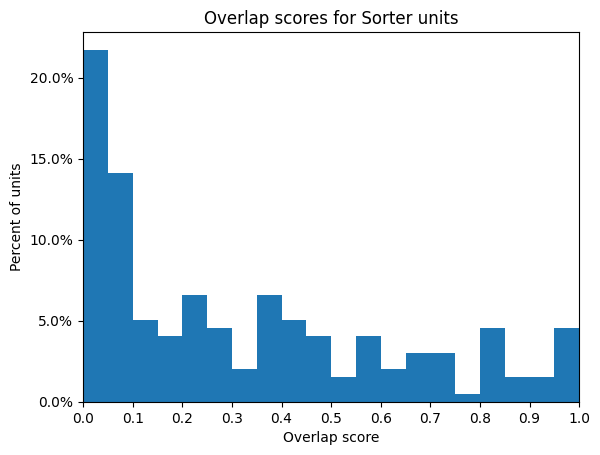

Num RT-Sort: 108
Num Sorter: 198
Num single matches: 68

For RT-Sort:
Num max matches: 69
Num unique max matches: 67

For Sorter:
Num max matches: 79
Num unique max matches: 68


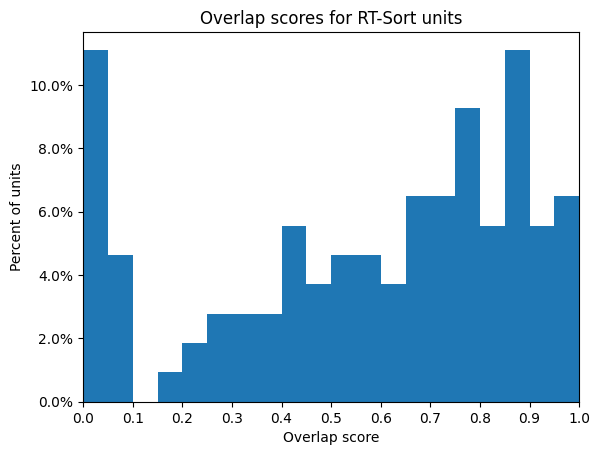

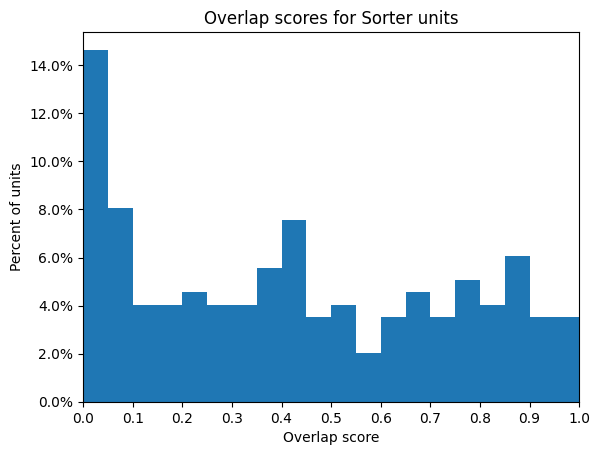

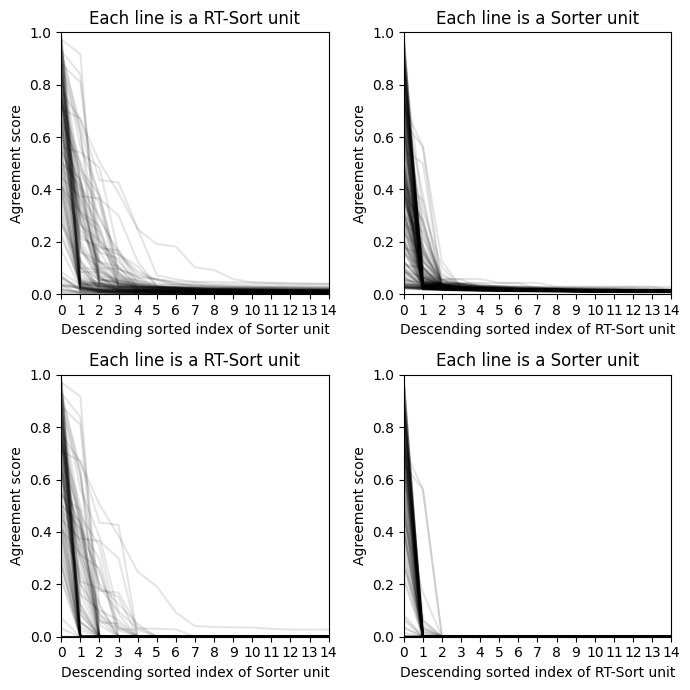

In [213]:
kilosort_dummy = DummySorter.units_to_sorter(merged_ks_units, name="Kilosort2")
_ = Comparison.full(prop_signal, kilosort_dummy)

### Only prop spikes within kilosort spikes

In [231]:
within_prop_units, outside_prop_units = F.select_prop_spikes_within_kilosort_spikes(prop_units, all_ks_units, RECORDING,
                                                                                    max_ms_dist=0.4, max_micron_dist=200)

25.9%


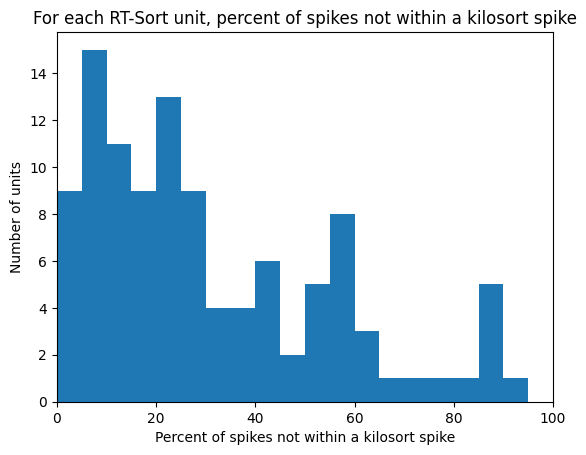

In [233]:
outside_percents = []
total_within = 0
total_outside = 0
for within, outside in zip(within_prop_units, outside_prop_units):
    within, outside = len(within.spike_train), len(outside.spike_train)
    total_within += within
    total_outside += outside
    outside_percents.append(outside / (outside+within) * 100)

print(f"{total_outside/(total_within + total_outside)*100:.1f}%")
plot.hist(outside_percents, xlim=(0, 100), bins=20)
plt.title("For each RT-Sort unit, percent of spikes not within a kilosort spike")
plt.xlabel("Percent of spikes not within a kilosort spike")
plt.ylabel("Number of units")
plt.show()

In [248]:
sorted_ind = np.argsort(outside_percents)
for idx in sorted_ind:
    print(idx, outside_percents[idx])

2 2.690582959641256
17 2.7777777777777777
45 3.2083755488010803
31 3.2841504045692527
78 3.793626707132018
46 3.8917089678511
90 4.262877442273535
69 4.819277108433735
13 4.886293792255685
72 5.217161016949152
51 5.2493438320209975
49 5.305692199578355
76 5.3550178500595
37 5.572380375529982
107 6.495263870094722
100 6.896551724137931
7 6.938603868797309
83 6.9699903194578905
50 7.168718320057929
4 8.045977011494253
11 8.743169398907105
38 8.83944678292243
85 9.150717703349283
91 9.35483870967742
32 10.0
20 10.335403726708075
88 10.52163604030824
16 10.760282509347736
64 11.036225779275483
36 11.252197694862277
33 12.009803921568627
23 13.716245177882556
6 14.144996059889678
59 14.719710669077756
81 14.735772357723578
35 15.052508751458577
84 15.300546448087433
62 15.384615384615385
86 16.773504273504273
15 16.92876965772433
65 17.37012987012987
34 18.6039803865013
22 19.3596425912137
12 19.44129860324651
30 20.342205323193916
8 20.38961038961039
103 20.393974507531865
41 20.9955841027

53.66% percent of spikes not within a kilosort spike


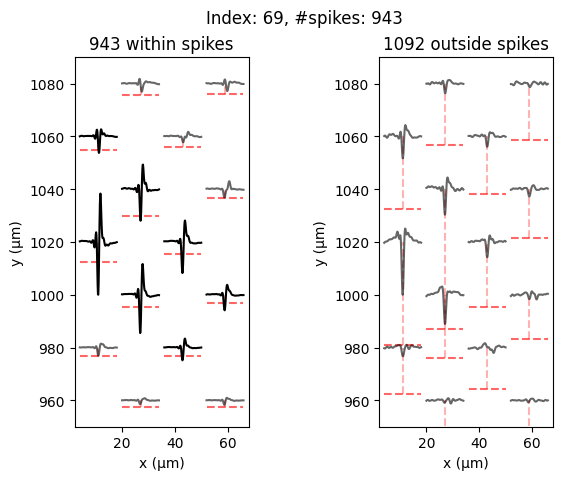

In [257]:
# np.random.seed(501)
# for idx in np.random.choice(len(within_prop_units), 6):
for idx in [44]:
    within, outside, outside_percent = within_prop_units[idx], outside_prop_units[idx], outside_percents[idx]

# for within, outside, outside_percent in zip(within_prop_units, outside_prop_units, outside_percents):
    # if outside_percent < 20:
    #     continue
    
    fig, axes = plt.subplots(1, 2, figsize=(7.2, 4.8))
    # kwargs = within.plot(subplot=(fig, axes[0]), chans_rms=CHANS_RMS)
    kwargs = within.plot(axis=axes[0], chans_rms=CHANS_RMS)
    fig.suptitle(axes[0].get_title())
    axes[0].set_title(f"{len(within.spike_train)} within spikes")
    # outside.plot(subplot=(fig, axes[1]), **kwargs)
    outside.plot(axis=axes[1], chans_rms=CHANS_RMS)# outside.plot(axis=axes[1], **kwargs)
    axes[1].set_title(f"{len(outside.spike_train)} outside spikes")
    print(f"{outside_percent:.2f}% percent of spikes not within a kilosort spike")
    plt.show()

4.0% percent of spikes not within a kilosort spike


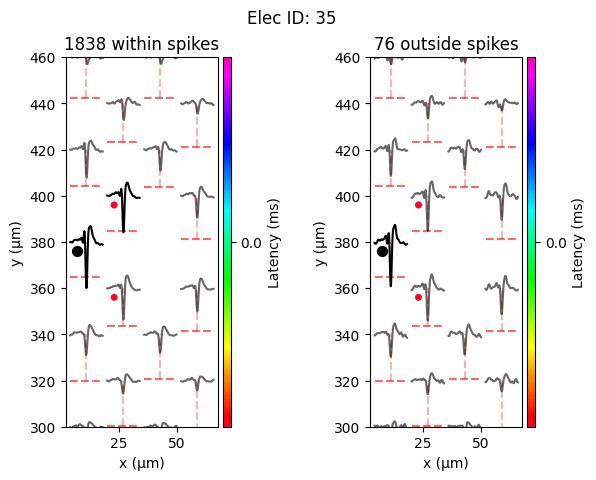

In [ ]:
# Look at a specific example
# IDX = 12
# within, outside, outside_percent = within_prop_units[IDX], outside_prop_units[IDX], outside_percents[IDX]

# fig, axes = plt.subplots(1, 2, figsize=(7.2, 4.8))
# kwargs = within.plot(subplot=(fig, axes[0]), chans_rms=CHANS_RMS)
# fig.suptitle(axes[0].get_title())
# axes[0].set_title(f"{len(within.spike_train)} within spikes")
# outside.plot(subplot=(fig, axes[1]), **kwargs)
# axes[1].set_title(f"{len(outside.spike_train)} outside spikes")
# print(f"{outside_percent:.1f}% percent of spikes not within a kilosort spike")
# plt.show()

/data/MEAprojects/PropSignal/src/comparison.py:334: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)


Num Sorter: 108
Num Uppermerged Kilosort: 91
Num single matches: 35

For Sorter:
Num max matches: 36
Num unique max matches: 35

For Uppermerged Kilosort:
Num max matches: 35
Num unique max matches: 35


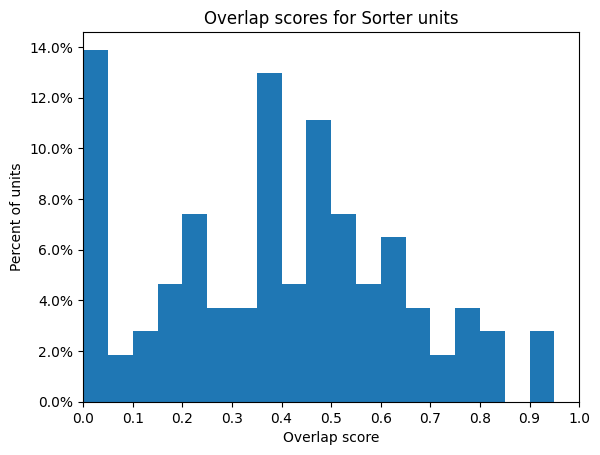

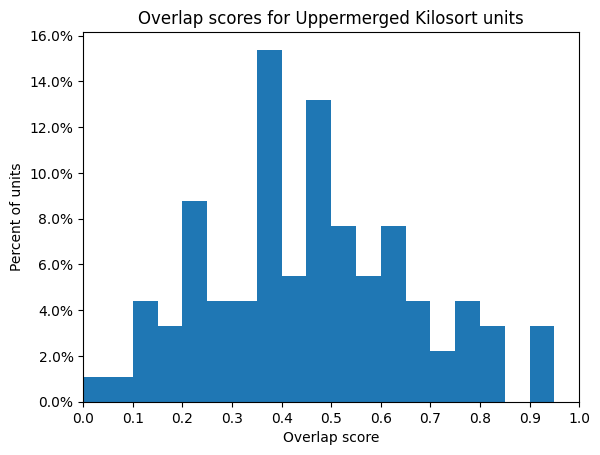

Num Sorter: 108
Num Uppermerged Kilosort: 91
Num single matches: 84

For Sorter:
Num max matches: 101
Num unique max matches: 81

For Uppermerged Kilosort:
Num max matches: 84
Num unique max matches: 83


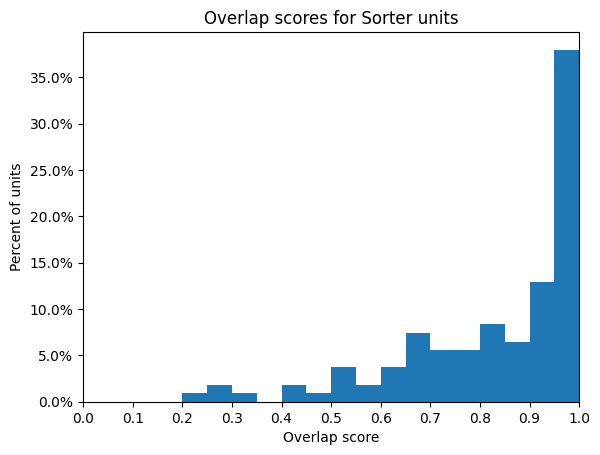

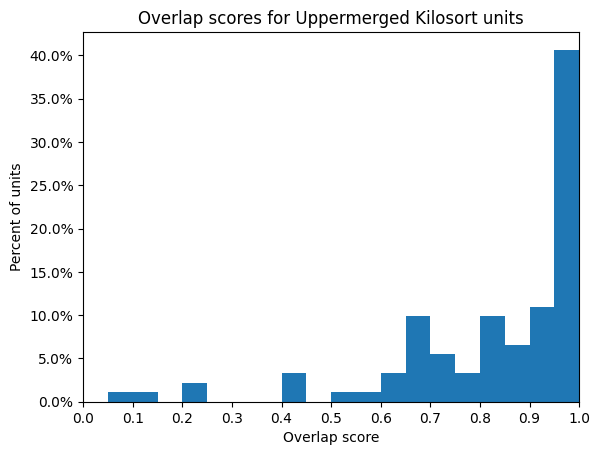

Num Sorter: 108
Num Uppermerged Kilosort: 91
Num single matches: 43

For Sorter:
Num max matches: 45
Num unique max matches: 43

For Uppermerged Kilosort:
Num max matches: 43
Num unique max matches: 43


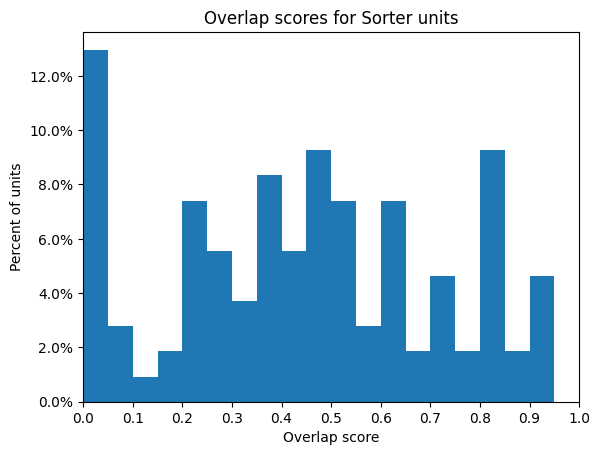

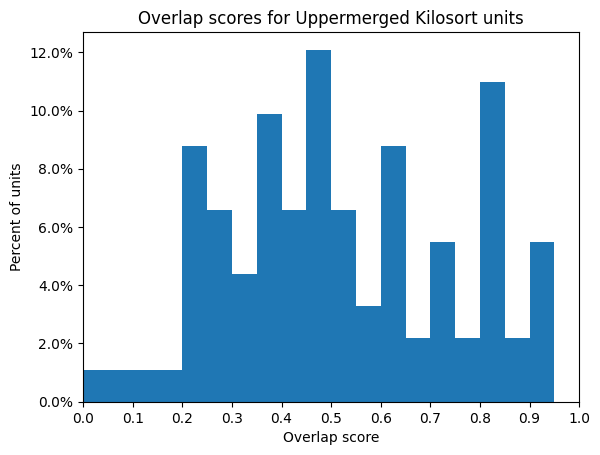

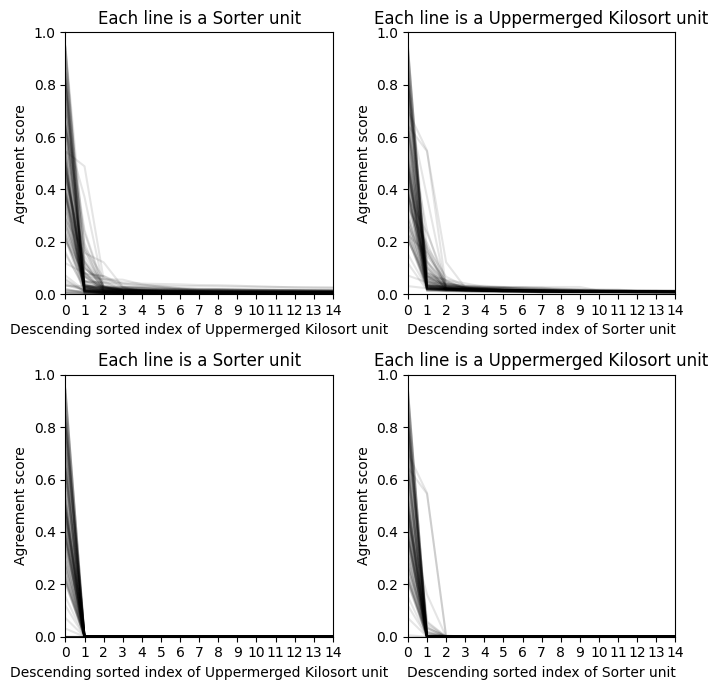

In [243]:
prop_dummy = DummySorter.units_to_sorter([unit for unit in within_prop_units if len(unit.spike_train) > 0], name="RT-Sort")
_ = Comparison.full(prop_dummy, uppermerged_kilosort)
# _ = Comparison.full(prop_dummy, kilosort)

### Only kilosort spikes within prop spikes
NOTE: Variable names are reversed. I.e. prop means kilosort and kilosort means prop

In [134]:
prop_units = [unit for unit in prop_signal]
within_prop_units, outside_prop_units = F.select_prop_spikes_within_kilosort_spikes(all_ks_units, prop_units, RECORDING,
                                                                                    max_ms_dist=0.4, max_micron_dist=200)

45.7%


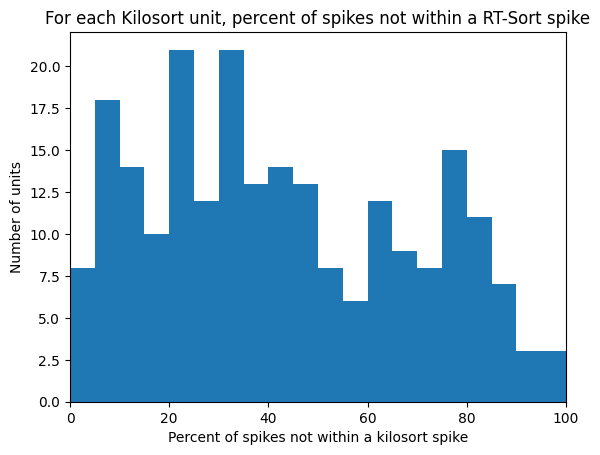

In [136]:
outside_percents = []
total_within = 0
total_outside = 0
for within, outside in zip(within_prop_units, outside_prop_units):
    within, outside = len(within.spike_train), len(outside.spike_train)
    total_within += within
    total_outside += outside
    outside_percents.append(outside / (outside+within) * 100)

print(f"{total_outside/(total_within + total_outside)*100:.1f}%")
plot.hist(outside_percents, xlim=(0, 100), bins=20)
plt.title("For each Kilosort unit, percent of spikes not within a RT-Sort spike")
plt.xlabel("Percent of spikes not within a kilosort spike")
plt.ylabel("Number of units")
plt.show()

In [137]:
sorted_ind = np.argsort(outside_percents)
for idx in sorted_ind:
    print(idx, outside_percents[idx])

33 1.8518518518518516
87 2.881152460984394
3 4.028021015761821
193 4.25531914893617
72 4.455445544554455
207 4.740904079382579
70 4.791666666666667
79 4.878048780487805
138 5.633802816901409
0 5.6657223796034
71 6.11974859411181
144 6.3296903460837886
107 6.504065040650407
124 6.7175572519083975
159 6.944444444444445
75 7.48502994011976
145 7.581227436823104
100 7.6072234762979685
119 7.917261055634807
38 8.099173553719009
109 8.16326530612245
181 8.214285714285714
140 8.870453095086152
60 9.008264462809917
36 9.52970297029703
148 9.612141652613827
204 10.67297581493165
5 10.748560460652591
205 10.766045548654244
208 10.919540229885058
149 11.11111111111111
81 11.291963377416073
63 12.875
123 13.444108761329304
97 13.737201365187712
190 13.745454545454546
137 13.953488372093023
194 14.346590909090908
111 14.506359781950334
198 14.852941176470589
203 15.60328490208465
16 15.684976836532098
101 16.539717083786726
6 16.966966966966968
189 17.857142857142858
105 18.433818433818434
25 18.88

65.60% percent of spikes not within a RT-Sort spike


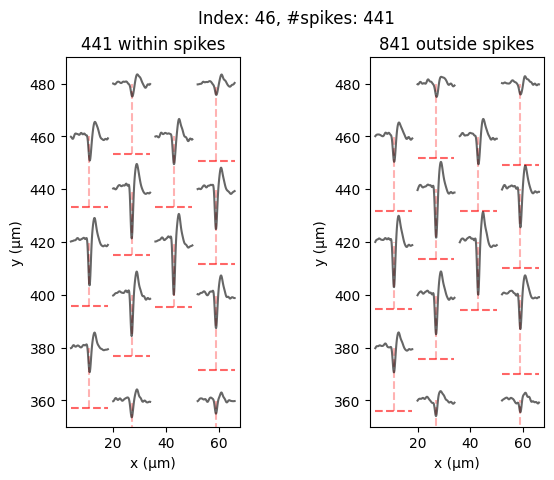

72.34% percent of spikes not within a RT-Sort spike


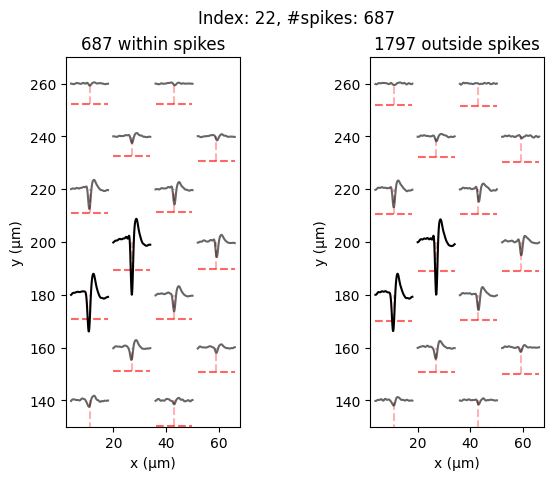

85.15% percent of spikes not within a RT-Sort spike


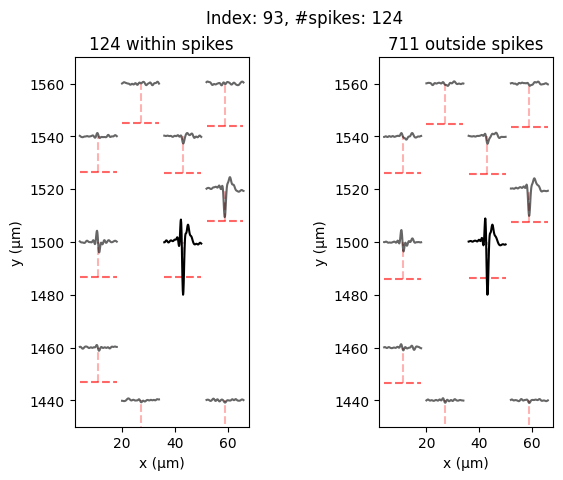

95.74% percent of spikes not within a RT-Sort spike


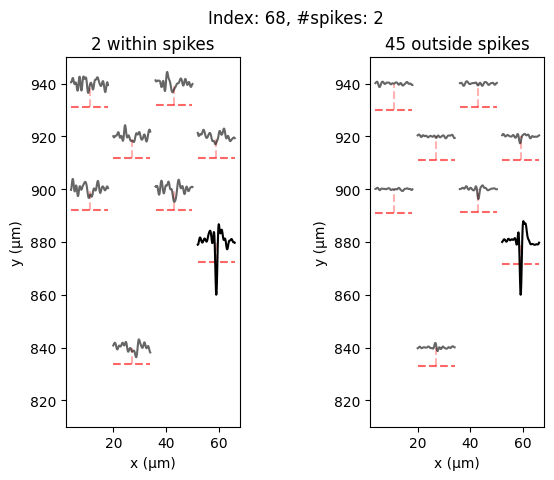

In [145]:
# np.random.seed(501)
# for idx in np.random.choice(len(within_prop_units), 6):
for idx in [46, 22, 93, 68]:
    within, outside, outside_percent = within_prop_units[idx], outside_prop_units[idx], outside_percents[idx]

# for within, outside, outside_percent in zip(within_prop_units, outside_prop_units, outside_percents):
    # if outside_percent < 20:
    #     continue
    
    fig, axes = plt.subplots(1, 2, figsize=(7.2, 4.8))
    # kwargs = within.plot(subplot=(fig, axes[0]), chans_rms=CHANS_RMS)
    kwargs = within.plot(axis=axes[0], chans_rms=CHANS_RMS)
    fig.suptitle(axes[0].get_title())
    axes[0].set_title(f"{len(within.spike_train)} within spikes")
    # outside.plot(subplot=(fig, axes[1]), **kwargs)
    outside.plot(axis=axes[1], chans_rms=CHANS_RMS)# outside.plot(axis=axes[1], **kwargs)
    axes[1].set_title(f"{len(outside.spike_train)} outside spikes")
    print(f"{outside_percent:.2f}% percent of spikes not within a RT-Sort spike")
    plt.show()